In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import maxentep
from maxentep import MetaModel, traj_quantile, patch_quantile, contact_infection_func
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
plt.style.use('seaborn-darkgrid')
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')


In [2]:
# uncomment to disable GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
# reduce memory usage, in case you're
# on a machine with 1 GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
print (gpus)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        _tf_on_gpu = True
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

[]


In [3]:
def compare_to_ref(ref_traj, trajs, weights, *args, method = None, figsize=(18, 18), patch_names=None, ** kw_args):
    '''does traj_quantile for trajectories of shape [ntrajs, time, patches, compartments]
    '''
#     weights = weights_dict[method]
#     p = 1
    NP = trajs.shape[2]
    nrow = int(np.floor(np.sqrt(NP)))
    ncol = int(np.ceil(NP / nrow))
    print(f'Plotting {NP} patches in a {nrow} x {ncol} grid')
    fig, ax = plt.subplots(nrow, ncol, sharex=True,
                           sharey=True, figsize=figsize)
    if method =='unbiased':
        fig.suptitle('{}'.format(method), fontsize=30,y=1.02)
    else:
        fig.suptitle('{} (Patches restrained: {}, Points restrained in each patch: {}, Compartments restrained: {})'
                     .format(method,len(restrained_patches),npoints*number_of_restrained_compartments,restrained_compartments_names)
                     , fontsize=26,y=1.002)
    for i in range(nrow):
        for j in range(ncol):
            if i * ncol + j == NP:
                break
#             traj_quantile(trajs[:,:,i * ncol + j,:], weights=weights, names=full_compartments, ax=axs[0,i])
            ax[i,j].plot(ref_traj[p,:,i * ncol + j,:], linestyle='--')
            if method == 'unbiased':
                traj_quantile(trajs[:, :, i * ncol + j, :], *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'biased':
                traj_quantile(trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'hyper-biased':
                traj_quantile(hme_model.trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'regression':
                ax[i,j].plot(rtraj[p,:,i * ncol + j,:])
#             ax[i, j].set_ylim(0, 1)
#             if i * ncol + j in restrained_patches and method != 'unbiased':
#                 for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i * ncol + j)]):
#                     pf(ax[i,j],0, color='C3')
#                 ax[i,j].spines['bottom'].set_color('y')
#                 ax[i,j].spines['top'].set_color('y') 
#                 ax[i,j].spines['right'].set_color('y')
#                 ax[i,j].spines['left'].set_color('y')
#                 ax[i,j].spines['left'].set_linewidth(2)
#                 ax[i,j].spines['top'].set_linewidth(2)
#                 ax[i,j].spines['right'].set_linewidth(2)
#                 ax[i,j].spines['bottom'].set_linewidth(2)
#             plt.tight_layout()
            if patch_names is None:
                ax[i, j].text(trajs.shape[1] // 2, 0.8,
                              f'Patch {i * ncol + j}')
            else:
                patch_names = patch_names
                ax[i, j].set_title(patch_names[i * ncol + j])

            if j == 0 and i == nrow // 2:
                ax[i, j].set_ylabel('Fraction')
            if i == nrow - 1 and j == ncol // 2:
                ax[i, j].set_xlabel('Time')
    plt.tight_layout()


## Reference Model

In [4]:
# Loading trajectory
results=pd.read_csv('Resultscounty.txt',header=None,sep='\t')
results.columns=['ID','time','county','S','E','A','I','R','P','D']
# results=pd.merge(results,parameters,on='ID')
results.sort_values(['ID','time'],ascending=True,inplace=True)
dictionary=pd.read_csv('countydictionary.csv')
dictionary.columns=['COUNTY CODE','COUNTY NAME','county']
results=pd.merge(results,dictionary,on='county')
# results=resultspatch[['time','COUNTY NAME','S','E','A','I','R','P','D','beta','tauexposed','taupresymp','tauI','casefatalityrate','COUNTY CODE']]  
results=results[['ID','time','COUNTY NAME','S','E','A','I','R','P','D']]
results.loc[:,"S":"D"] = results.loc[:,"S":"D"].div(results.loc[:,"S":"D"].sum(axis =1), axis=0)
population =pd.read_csv('popCounty.txt',index_col=False,names=['ID','Population'],header=None,sep=' ')['Population'].tolist()
population_fraction = population/np.sum(population)
area =pd.read_csv('areaCounty.txt',index_col=False,names=['ID','Area'],header=None,sep=' ')['Area'].tolist()
# Getting number of patches
patches = np.unique(results['COUNTY NAME'].values)
M = len(patches)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


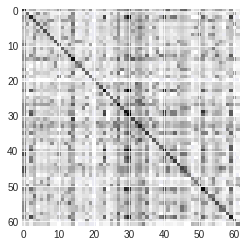

In [5]:
# load mobility matrix
networkCounty=pd.read_csv('networkCounty.txt',header=None,sep=' ')
networkCounty.columns=['ID','County','mobility_parameter']
# mobility_matrix = networkCounty.reset_index().groupby(['County'])['mobility_parameter'].apply(np.array).to_numpy()
# networkCounty = networkCounty[['ID','mobility_parameter']]
mobility_matrix = np.empty([0,M])
mobility_parameter_row = np.zeros(M)
for i,row in networkCounty.iterrows():
    mobility_parameter_row[networkCounty.loc[i, 'County']] = networkCounty.loc[i, 'mobility_parameter']
    if i < networkCounty.shape[0]-1:
        if networkCounty.loc[i+1, 'County'] == 0:
            mobility_matrix = np.append(mobility_matrix, [mobility_parameter_row], axis=0)
    #         print(mobility_parameter_row)
            mobility_parameter_row = np.zeros(M)
    else:
         mobility_matrix = np.append(mobility_matrix, [mobility_parameter_row], axis=0)

assert (np.shape(mobility_matrix)==(M,M))
mobility_matrix_norm = mobility_matrix / np.sum(mobility_matrix, axis=1, keepdims=True)
print (np.sum(mobility_matrix_norm, axis =1))
plt.imshow(np.log(mobility_matrix))

In [6]:
# Getting the time length
time_S = np.unique(results['time'].values)
Time_S = len(time_S)
# Getting number of trajectories
IDs = np.unique(results['ID'].values)
N = len(IDs)
np.set_printoptions(threshold=np.inf)
# Number of compartments
C = 7
ref_traj = np.empty((N, Time_S, M, C))
# start_time = 30
# end_time = 75
for n in IDs:
    for m, patch_name in enumerate(patches):
        ID = results.loc[results['ID'].isin([str(n)])]
        county = ID.loc[ID['COUNTY NAME'] == patch_name]
        traj_county = county[['S','E','A','I','R','P','D']].to_numpy()
        ref_traj[n,:,m,:] = traj_county
           
start_time = 0
end_time = 201  

Time = end_time - start_time
p = 0
# ref_traj = ref_traj[:, start_time:end_time,:,:]
## Combining P and D compartments into R
ref_traj[p,:,:,4] +=  ref_traj[p,:,:,5] + ref_traj[p,:,:,6]
ref_traj = ref_traj[p,:,:,:5]
# REF=ref_traj

# ref_traj = ref_traj[:,:,:]
ref_traj = ref_traj[np.newaxis,:,:,:]


Plotting 62 patches in a 7 x 9 grid


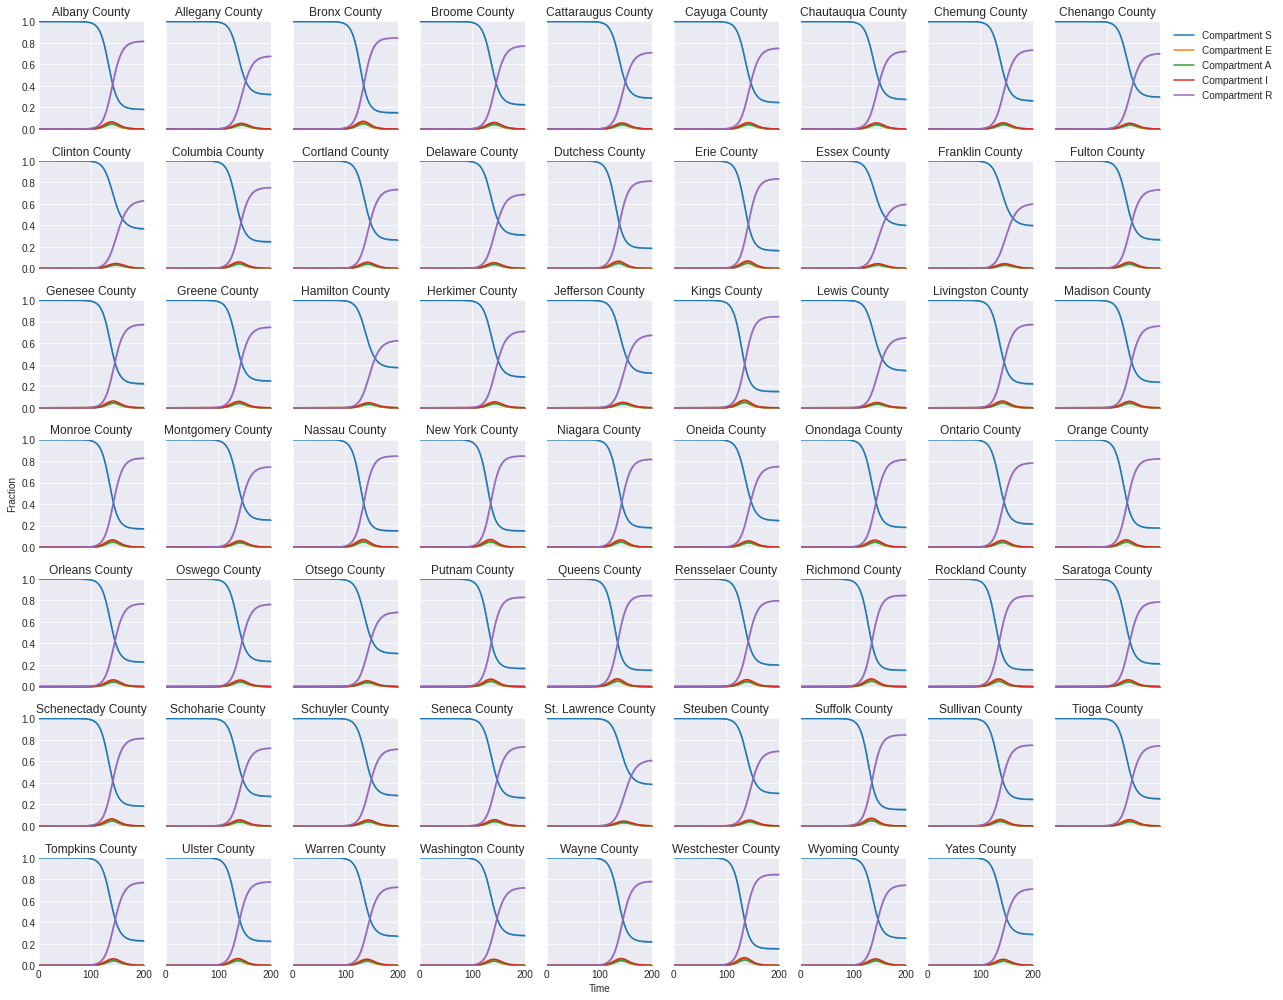

In [7]:
patch_quantile(ref_traj, patch_names = patches, figsize=(18, 14), alpha=0.5, names=['S','E','A','I','R'])
# plt.suptitle("Reference data", size=25, y=1.001)
# plt.tight_layout()
# plt.savefig('patch_quantile.png',dpi=400)
# population[0:10]
# beta = np.array([0.028905,0.052113])
# beta.shape[0]

In [8]:
## make a maxentep traj to compare 
# compartment parameters
# compartments = ['E', 'A', 'I', 'R']
# full_compartments = ['S'] + compartments
# infections_compartments = [1,2]
# C = len(compartments)
# tmat = maxentep.TransitionMatrix(compartments, [1,2])
# eta = 1/2.492673
# # alpha = 1/4
# mu = 1/4.897089
# epsilon = 0.586028
# tmat.add_transition('E', 'A', 1/eta/(1-epsilon), 0)
# tmat.add_transition('E', 'I', 1/eta/epsilon, 0)
# tmat.add_transition('A', 'R', 1/mu, 0)
# tmat.add_transition('I', 'R', 1/mu, 0)

# infect_fxn = maxentep.contact_infection_func(infections_compartments, area=area)
# timesteps = 202
# model = maxentep.MetaModel(infect_fxn, timesteps, populations=np.array(population))

# # starting fractions probabilities
# start = np.zeros((M,C)) #anywhere
# # assume starting from Bronx county
# exposed_Bronx = 1/population[2]
# start[2,0] = exposed_Bronx
# # start[0,0] = 0.05
# beta = np.array([0.028905,0.052113])
# m_ref_traj = model(mobility_matrix_norm, tmat.value, start, beta)[0]
# m_ref_traj = m_ref_traj[np.newaxis,:,:,:]

# m_ref_traj.shape

In [9]:
# compare_to_ref(ref_traj, m_ref_traj, weights=None, method='unbiased', patch_names = patches, figsize=(18, 14), alpha=0.3, names=full_compartments)

In [10]:
# patch_quantile(ref_traj, patch_names = patches, figsize=(18, 14), alpha=0.5, names=['S','E','A','I','R'])
# plt.suptitle("Reference data", size=25, y=1.001)
# plt.tight_layout()
# plt.savefig('patch_quantile.png',dpi=400)

In [11]:
# ## make a maxentep traj to compare 
# # compartment parameters
# compartments = ['E', 'A', 'I', 'R']
# full_compartments = ['S'] + compartments
# infections_compartments = [1,2]
# C = len(compartments)
# tmat = maxentep.TransitionMatrix(compartments, [1,2])
# eta = 1/2.6
# alpha = 1/2.6
# mu = 1/3.2
# tmat.add_transition('E', 'A', 1/eta, 0)
# tmat.add_transition('A', 'I', 1/alpha, 0)
# tmat.add_transition('I', 'R', 1/mu, 0)

# infect_fxn = maxentep.contact_infection_func(infections_compartments, area=area)
# timesteps = 202
# model = maxentep.MetaModel(infect_fxn, timesteps, populations=np.array(population))

# # starting fractions probabilities
# start = np.zeros((M,C)) #anywhere
# # assume starting from Bronx county
# exposed_Bronx = 1/population[2]
# start[2,0] = exposed_Bronx
# # start[0,0] = 0.05
# beta = 0.04
# m_ref_traj = model(mobility_matrix_norm, tmat.value, start, beta)[0]
# ref_traj = m_ref_traj[np.newaxis,::,:]

# patch_quantile(ref_traj, patch_names = patches, figsize=(18, 14), alpha=0.5, names=['S','E','A','I','R'])

In [12]:
# patch_quantile(m_ref_traj, patch_names = patches, figsize=(18, 14), alpha=0.5, names=['S','E','A','I','R'])
# ref_traj = m_ref_traj
# total_pop = np.sum(population)
# R0 = 5
# t_max = np.log(total_pop)/mu/(R0-1)
# t_max

In [13]:
# Run this for creating frames for animations
import plotly.graph_objs as go
import plotly.figure_factory as ff 
process_traj = False
if process_traj == True:
    for t in range(T):
        infected_portion = [tf.round(ref_traj[0,t,i,3],2) for i in range(M)]
        zipcodes = dictionary['COUNTY CODE']
        fig = ff.create_choropleth(fips=zipcodes, 
                                   scope=['New York'],
                                   values=infected_portion,
                                   title='NY COVID-19 Infected Population Fraction by County',
                                   county_outline={'color': 'rgb(255,255,255)', 'width': 0.5},
                                   state_outline={'width': .5}
                                   )


        fig.update_layout(legend=dict(
            title='Infected Fraction',
            yanchor="top",
            y=0.95,
            xanchor="left",
            x=0.9,

        ))
        fig.add_annotation(dict(font=dict(color='black',size=30),
                                                x=0.4,
                                                y=0.12,
                                                showarrow=False,
                                                text="Day {}".format(t),
                                                textangle=0,
                                                xanchor='left',
                                                xref="paper",
                                                yref="paper"
                                                ))

        fig.layout.template = {'layout': {'font': {'family': 'Britannic Bold', 'size': 20}}}
        fig.write_image("NY_map//traj_" + str(t) +
                            ".png",width = 2048, height =1060)

# Run this for saving plots
if process_traj == True:
    for i in range(M):
        traj_quantile(ref_traj[:,:,i,:], names=['S','E','A','I','R','P','D'], add_legend=False, add_title = patches[i], plot_means=True)
        fig = plt.gcf()
        fig.set_size_inches(4, 4)
        #plt.savefig('{}.png'.format(patches[i]),dpi=400)
        plt.close()

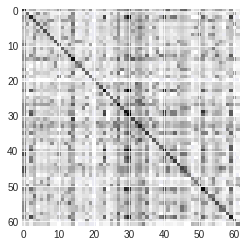

In [14]:
plt.imshow(np.log(mobility_matrix))

## Make restraints from reference trajectory

I R
Restraints are set in this time range: [90, 140]
108 0.010864001135027382 0.01028092218122281
115 0.022971701406282175 0.024140567819419523
122 0.04276442898279135 0.04209951620313901
129 0.06383994118290208 0.06318715481655951
94 0.00208254524152534 0.0011084243037555897
87 0.0008879782476676947 0.0009437682279200982
108 0.030270671813287093 0.030028409100995787
87 0.002372339195535349 0.0020739234114966467
101 0.013093443742027982 0.012233235440654315
129 0.2708331696258955 0.27071141247354524
136 0.43766570314741193 0.4374594407961359
115 0.06792467119924402 0.06760194273777967
94 0.0007049963439479152 0.0007228135129693315
101 0.0016736986738316996 0.0008471861588500653
122 0.01852961737648958 0.01820250601708946
115 0.008817172853658272 0.00974859079895794
129 0.034057615325165755 0.03223872635914296
136 0.05058177424870365 0.04986404198396058
122 0.05489533751832533 0.05366938310755202
87 0.0007615931059337061 0.0004424647979842475
115 0.024404608417157695 0.02341834508982138

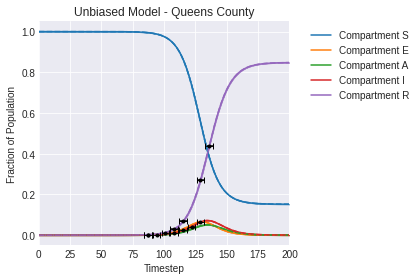

I R
[40 48 27  9 25 58 10 50 56  6 22 20  4  3 41]
40


In [15]:
compartments = ['E','A','I','R']
infections_compartments = [1,2]
full_compartments = ['S'] + compartments
npoints = 6
prior = maxentep.EmptyPrior()
# prior = maxentep.Laplace(0.1)
# p = 0

# restrained_patches = np.random.randint(M, size=number_of_restraint_patches)
number_of_restrained_patches = 15 
restrained_compartments = [3,4] #(infected patch and recovered)
restrained_compartments_names = [full_compartments[m] for m in restrained_compartments]
restrained_compartments_names = " ".join(restrained_compartments_names)
print (restrained_compartments_names)
number_of_restrained_compartments = len(restrained_compartments) 

restrained_patches = np.random.choice(M, number_of_restrained_patches, replace=False)

restrained_patch = restrained_patches[0]
# def compartment_restrainer(number_of_restrained_patches,number_of_restrained_compartments,npoints,ref_traj,prior,noise=0,time_average=7):
#     if number_of_restrained_patches > M:
#         raise ValueError(
#             "Oops! Number of patches to be restrained exceeeds the total number of patches.")
# #     p = 0  # picking one trajectory from the parameter set (pick the first 1)
#     # example if number_of_restraint_patches = 2 : (recovered and infected patch)
#     restraints =[] 
#     plot_fxns_list = []
#     for i in range(number_of_restrained_patches):
#         plot_fxns = []
#         for j in range(number_of_restrained_compartments):
#             res, plfxn = maxentep.traj_to_restraints(ref_traj[p,:80,:,:], [restrained_patches[i],restrained_compartments[j]], npoints, prior, noise,time_average)
#             restraints += res 
#             plot_fxns += plfxn
#         plot_fxns_list.append(plot_fxns)
#     return restraints, plot_fxns_list


restraints, plot_fxns_list = maxentep.compartment_restrainer(restrained_patches,
                                                    restrained_compartments,ref_traj, prior,npoints=npoints,
                                                    noise=1e-3,start_time=90, end_time=140)
maxentep.traj_quantile(ref_traj[:,:,restrained_patch,:], names=full_compartments, plot_means=True)
plt.plot(ref_traj[p,:,restrained_patch,:], linestyle='--')
plt.title('Unbiased Model - {}'.format(patches[restrained_patch]))
for i,pf in enumerate(plot_fxns_list[0]):
    pf(plt.gca(), 0)
plt.tight_layout()
plt.savefig('unbiased.png',dpi=200)
# plt.ylim(0,0.2)
# plt.xlim(0,75)
plt.show()
print (restrained_compartments_names)
print(restrained_patches)
print(restrained_patch)

## Restraining a sample SEAIRPD to reference

In [16]:
print(max(1/np.array(population)))
print(np.mean(1/np.array(population)))
print(np.var(1/np.array(population)))

0.00021222410865874363
1.6059567615649856e-05
7.469191736144403e-10


In [17]:
# compartment parameters
compartments = ['E','A','I','R']
infections_compartments = [1,2]
C = len(compartments)
tmat = maxentep.TransitionMatrix(compartments, infections_compartments)
eta = 1/2.492673
# alpha = 1/4
mu = 1/4.897089
# epsilon = 0.6
tmat.add_transition('E', 'A', 5, 2) # call this alpha
tmat.add_transition('E', 'I', 5, 2) # call this gamma
tmat.add_transition('A', 'R',6, 2) # mu
tmat.add_transition('I', 'R', 6, 2) # mu


print(tmat.value)
hyper_pram = maxentep.ParameterHypers()
hyper_pram.beta_low = [0.01]*2
# hyper_pram.beta_low = 0.001
# hyper_pram.beta_high = 0.04
hyper_pram.beta_high = [0.08]*2
hyper_pram.beta_var = [0.5]*2
# hyper_pram.start_high = 2e-4
hyper_pram.start_high = 2e-4
hyper_pram.R_var = 10
hyper_pram.beta_start = 0.04
hyper_pram.start_mean = 5e-5
hyper_pram.start_scale = 1e-7

start_logits = np.zeros((M))
param_model = maxentep.MetaParameterJoint(start_logits, mobility_matrix , tmat, name='unbiased_model', hypers = hyper_pram, n_infectious_compartments=2)

[[0.6        0.2        0.2        0.        ]
 [0.         0.83333333 0.         0.16666667]
 [0.         0.         0.83333333 0.16666667]
 [0.         0.         0.         1.        ]]


In [19]:
intial_exposed_guess = 1/np.array(population)
v = param_model.sample(10)
beta_dist = v[3]
# start_dist
# mask = tf.greater(start_dist, 0)
# start_exposed_dist = tf.boolean_mask(start_dist, mask).numpy()
# tf.reduce_mean(start_exposed_dist)
start_dist = v[2]
start_dist

<tf.Tensor: shape=(10, 62, 4), dtype=float32, numpy=
array([[[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00

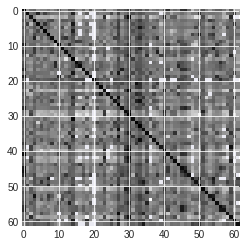

In [20]:
# Making sure our sample for mobility network is reasonable
R = v[0][8]
plt.imshow(np.log(R))

In [21]:
intial_exposed_guess = 1/np.array(population)
import tqdm
# N = 16384
N = 2048
batches = 8
total_batches= N*batches
outs = []
infect = maxentep.contact_infection_func(infections_compartments, area = area)
# model = maxentep.MetaModel(infect, Time,populations = np.round(population))
model = maxentep.MetaModel(infect, Time, populations = population)
prior_prams = []
for b in tqdm.tqdm(range(batches)):
    ps = param_model.sample(N)
#     R_dist= ps[0]
#     output_list = []
#     for i in range(R_dist.shape[0]):
#         R_dist_d = mobility_matrix
#         norm_R_dist_d = R_dist_d/ tf.math.reduce_sum(R_dist_d, axis = 1, keepdims=True)
#         output_list.append(norm_R_dist_d)
#     outputs = tf.stack(output_list)
#     ps[0] = outputs
    start_dist = ps[2]
    new_start_dist = np.zeros_like(start_dist)
    start_dist_list = []
    for i in range(start_dist.shape[0]):
        index = tf.where(start_dist[i]>0)[0][0].numpy()
        new_start_dist[i,index,0] = intial_exposed_guess[index]
    start_dist_list.append(new_start_dist)
    outputs = tf.stack(start_dist_list, axis =0)
    ps[2] = tf.squeeze(outputs)
    prior_prams.append(ps)
    outs.append(model(*ps))
trajs = np.concatenate(outs, axis=0)
# trajs = trajs[:,start_time:end_time,:,:]
print(trajs.shape)

100%|██████████| 8/8 [01:44<00:00, 13.06s/it]


(16384, 201, 62, 5)


## Visualizing the unbiased traj

Plotting 62 patches in a 7 x 9 grid


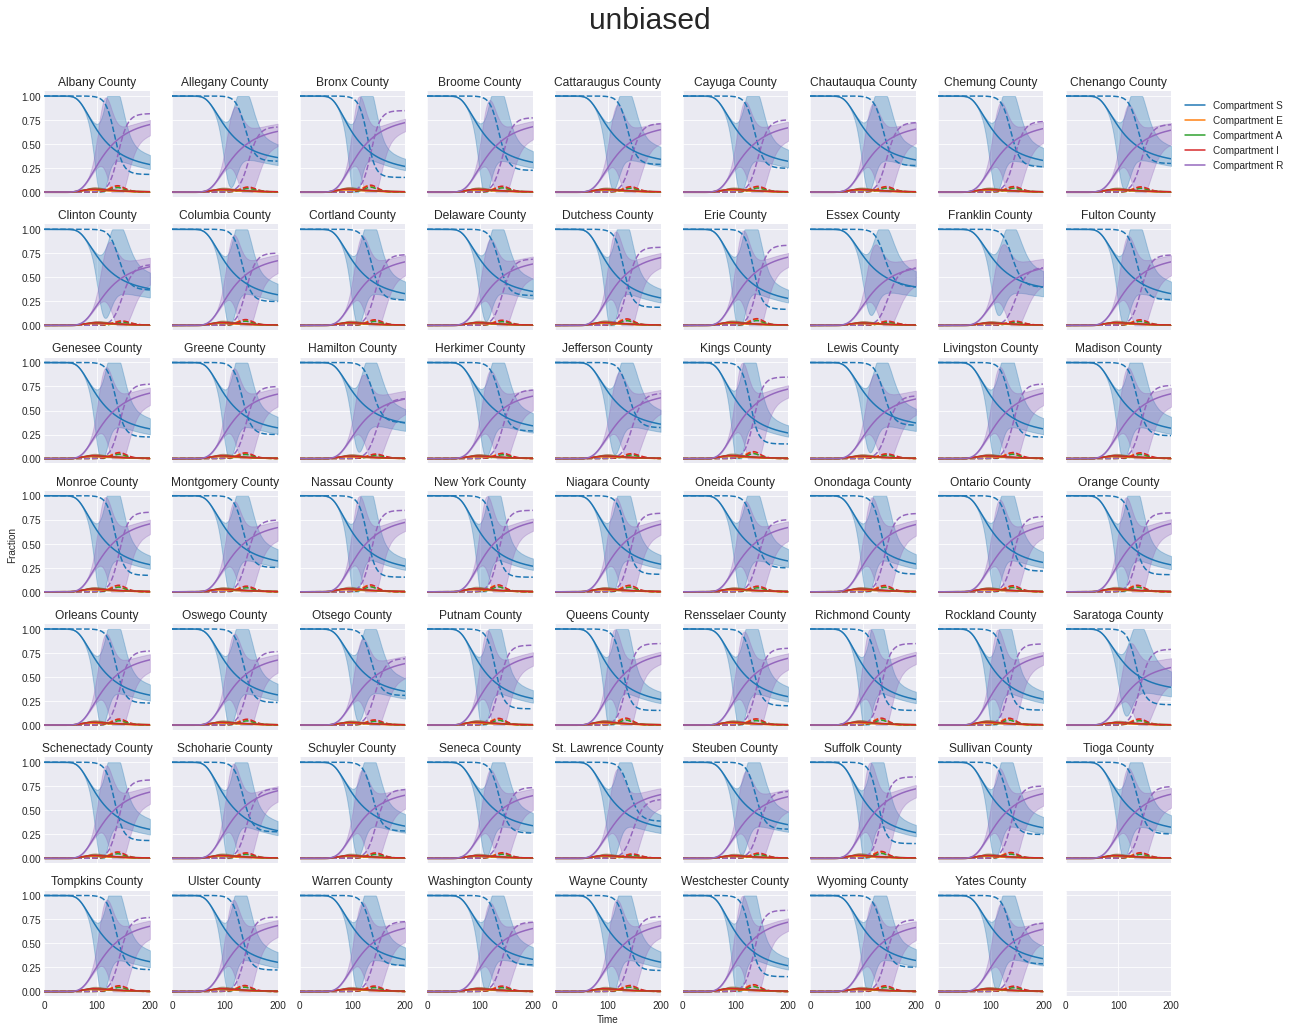

In [22]:
# compartment parameters
compartments = ['E', 'A', 'I', 'R']
full_compartments = ['S'] + compartments
compare_to_ref(ref_traj,trajs, weights=None, method='unbiased', patch_names = patches, 
               figsize=(18, 14), alpha=0.3, names=full_compartments)

<AxesSubplot:ylabel='Count'>

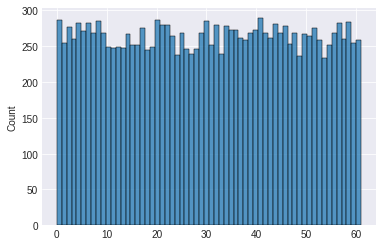

In [23]:
prior_exposed_patch = maxentep.exposed_finder(trajs)
sns.histplot(x=prior_exposed_patch, label='Prior', color='C0',bins=M)

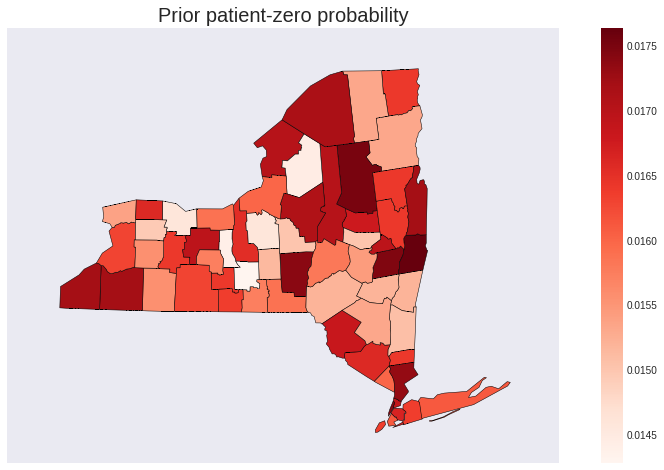

In [24]:
maxentep.p0_map(prior_exposed_patch, M, weights = None, patch_names=patches, title = 'Prior patient-zero probability',
                fontsize=20, choropleth=True,
       geojson='counties_ny.geojson')

In [25]:
def get_dist(prior_prams):
    R_dist = []
    T_dist = []
    start_dist = []
    beta_dist = []
    for i in range(len(prior_prams)):
        param_batch = prior_prams[i]
#         R_dist.append(param_batch[0])
        T_dist.append(param_batch[1])
        start_dist.append(param_batch[2])
        beta_dist.append(param_batch[3])
#     R_dist = tf.concat(R_dist, axis = 0)
    T_dist = tf.concat(T_dist, axis = 0)
    start_dist = tf.concat(start_dist, axis = 0)
    beta_dist = tf.concat(beta_dist, axis = 0)
    # get eta^-1
    E_A = 1/T_dist[:, compartments.index('E'), compartments.index('A')].numpy()
    # get gamma^-1
    E_I = 1/T_dist[:, compartments.index('E'), compartments.index('I')].numpy()
    # get mu^-1
    A_R = 1/T_dist[:, compartments.index('A'), compartments.index('R')].numpy()
    # get mu^-1
    I_R = 1/T_dist[:, compartments.index('I'), compartments.index('R')].numpy()
    # Getting starting exposed fraction 
    mask = tf.greater(start_dist, 0)
    start_exposed_dist = tf.boolean_mask(start_dist, mask).numpy()
    return [E_A, E_I,A_R, I_R, start_exposed_dist, beta_dist]
    
def plot_dist(E_A, E_I, A_R, I_R, start_exposed_dist, beta_dist, name='Prior'):
    import seaborn as sns
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,6), dpi=200)
    fig.suptitle(f'{name} distributions', fontsize=25,y=1.00)
    sns.distplot(x=beta_dist[...,0], ax = axs[0,0], axlabel=r'$\beta_{A}$')
    sns.distplot(x=beta_dist[...,1], ax = axs[0,1], axlabel=r'$\beta_{I}$')
    sns.distplot(x=E_A, ax = axs[0,2], axlabel=r'$\alpha^{-1}$ : E->A (days)')
    sns.distplot(x=E_I, ax = axs[1,0], axlabel=r'$\gamma^{-1}$ : E->I (days)')
    sns.distplot(x=A_R, ax = axs[1,1], axlabel=r'$\mu_{A}^{-1}$ : A->R (days)')
    sns.distplot(x=I_R, ax = axs[1,2], axlabel=r'$\mu_{I}^{-1}$ : I->R (days)')
#     sns.distplot(x=E_A, ax = axs[1,0], axlabel=r'$\eta^{-1}$ : E->A (days)')
#     sns.distplot(x=A_I, ax = axs[1,1], axlabel=r'$\alpha ^{-1}$ : A->I (days)')
#     sns.distplot(x=I_R, ax = axs[1,1], axlabel=r'$\mu^{-1}$ : I->R (days)')

In [26]:
prior_param_dist = get_dist(prior_prams)

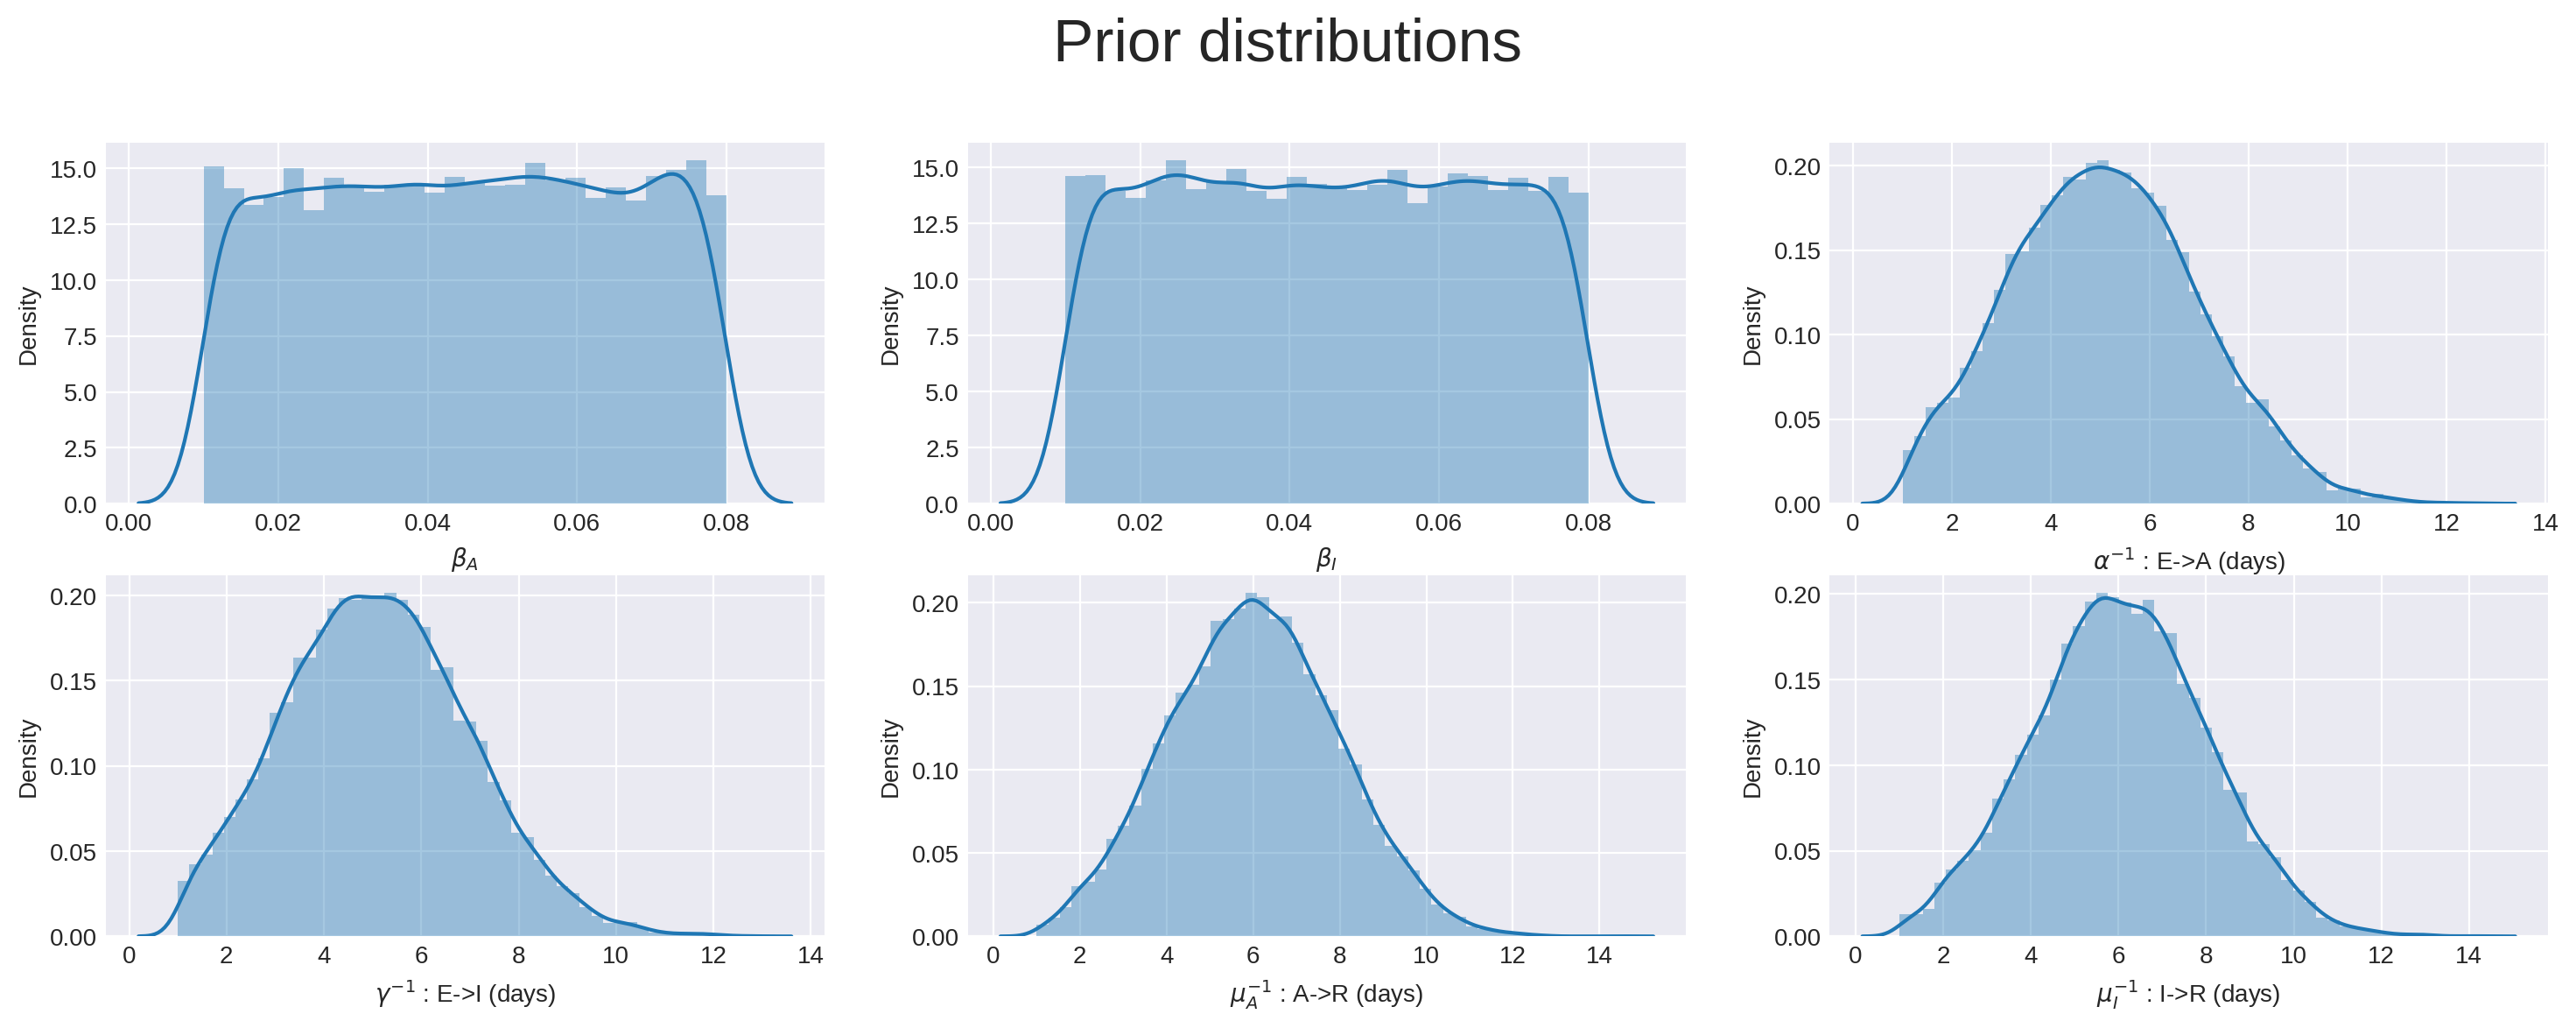

In [27]:
plot_dist(*prior_param_dist)

In [28]:
# ref_traj = tf.squeeze(ref_traj)
# if tf.rank(ref_traj).numpy() != 4:
#     ref_traj = ref_traj[tf.newaxis, ...]
# ref_traj.shape

In [29]:

# print (restrained_compartments_names)
# npoints =4
# prior = maxentep.EmptyPrior()
# cutting the ref_traj in half
# restraints_R, plot_fxn_R = maxentep.traj_to_restraints(ref_traj[p,:75,:,:], [restrained_patch,4], npoints, prior, noise=0,time_average=7)
#restraints_E, plot_fxn_E = maxentep.traj_to_restraints(ref_traj[p,:75,:,:], [0,1], npoints, prior, noise=0,time_average=7)
#restraints_A, plot_fxn_A = maxentep.traj_to_restraints(ref_traj[p,:75,:,:], [0,2], npoints, prior, noise=0,time_average=7)
# restraints_I, plot_fxn_I = maxentep.traj_to_restraints(ref_traj[p,:75,:,:], [restrained_patch,3], npoints, prior, noise=0,time_average=7)
#restraints_P, plot_fxn_P = maxentep.traj_to_restraints(ref_traj[p,:75,:,:], [0,5], npoints, prior, noise=0,time_average=7)
#restraints_D, plot_fxn_D = maxentep.traj_to_restraints(ref_traj[p,:75,:,:], [0,6], npoints, prior, noise=0,time_average=7)
#restraints = restraints_R + restraints_E + restraints_A + restraints_I + restraints_P + restraints_D
#plot_fxns = plot_fxn_R + plot_fxn_E + plot_fxn_A + plot_fxn_I + plot_fxn_P + plot_fxn_D
# restraints = restraints_I + restraints_R
# plot_fxns = plot_fxn_I + plot_fxn_R


In [30]:
me_model = maxentep.MaxentModel(restraints)
me_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-1), 'mean_squared_error')

In [31]:
# class CustomCallback(tf.keras.callbacks.Callback):
#     def __init__(self):
#         self. i = 0
#     def on_epoch_begin(self, epoch, logs=None):
#         self.i += 1
#         return self.i


In [32]:
me_history = me_model.fit(trajs, batch_size=N//2,epochs=1000)#, callbacks=[CustomCallback()])

Epoch 1/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0073 - weight-entropy: 6.1097
Epoch 2/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0053 - weight-entropy: 6.0122
Epoch 3/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0045 - weight-entropy: 6.0406
Epoch 4/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0015 - weight-entropy: 4.7201
Epoch 5/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 5.4180
Epoch 6/1000
16/16 [==============================] - 0s 1ms/step - loss: 7.7272e-04 - weight-entropy: 4.8044
Epoch 7/1000
16/16 [==============================] - 0s 1ms/step - loss: 6.5534e-04 - weight-entropy: 4.7293
Epoch 8/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0010 - weight-entropy: 5.2730
Epoch 9/1000
16/16 [==============================] - 0s 1ms/step - loss: 7.1462e-04 - weight-entropy: 4.6609
Epoch 10/1000
16/16 [=============

16/16 [==============================] - 0s 1ms/step - loss: 1.3022e-04 - weight-entropy: 5.6552
Epoch 76/1000
16/16 [==============================] - 0s 1ms/step - loss: 1.4276e-04 - weight-entropy: 5.6519
Epoch 77/1000
16/16 [==============================] - 0s 1ms/step - loss: 1.3363e-04 - weight-entropy: 5.6480
Epoch 78/1000
16/16 [==============================] - 0s 1ms/step - loss: 1.3707e-04 - weight-entropy: 5.6496
Epoch 79/1000
16/16 [==============================] - 0s 1ms/step - loss: 1.3569e-04 - weight-entropy: 5.6460
Epoch 80/1000
16/16 [==============================] - 0s 1ms/step - loss: 1.4402e-04 - weight-entropy: 5.6515
Epoch 81/1000
16/16 [==============================] - 0s 1ms/step - loss: 1.3175e-04 - weight-entropy: 5.6461
Epoch 82/1000
16/16 [==============================] - 0s 1ms/step - loss: 1.2691e-04 - weight-entropy: 5.6522
Epoch 83/1000
16/16 [==============================] - 0s 1ms/step - loss: 1.2653e-04 - weight-entropy: 5.6368
Epoch 84/1000
1

16/16 [==============================] - 0s 1ms/step - loss: 9.4321e-05 - weight-entropy: 5.4712
Epoch 149/1000
16/16 [==============================] - 0s 1ms/step - loss: 9.3099e-05 - weight-entropy: 5.4665
Epoch 150/1000
16/16 [==============================] - 0s 1ms/step - loss: 9.7579e-05 - weight-entropy: 5.4566
Epoch 151/1000
16/16 [==============================] - 0s 1ms/step - loss: 9.0864e-05 - weight-entropy: 5.4559
Epoch 152/1000
16/16 [==============================] - 0s 1ms/step - loss: 9.5339e-05 - weight-entropy: 5.4583
Epoch 153/1000
16/16 [==============================] - 0s 1ms/step - loss: 1.0096e-04 - weight-entropy: 5.4589
Epoch 154/1000
16/16 [==============================] - 0s 1ms/step - loss: 9.9086e-05 - weight-entropy: 5.4581
Epoch 155/1000
16/16 [==============================] - 0s 1ms/step - loss: 8.7604e-05 - weight-entropy: 5.4419
Epoch 156/1000
16/16 [==============================] - 0s 1ms/step - loss: 9.7771e-05 - weight-entropy: 5.4536
Epoch 1

16/16 [==============================] - 0s 1ms/step - loss: 7.6786e-05 - weight-entropy: 5.2354
Epoch 222/1000
16/16 [==============================] - 0s 1ms/step - loss: 7.8815e-05 - weight-entropy: 5.2501
Epoch 223/1000
16/16 [==============================] - 0s 1ms/step - loss: 8.4243e-05 - weight-entropy: 5.2022
Epoch 224/1000
16/16 [==============================] - 0s 1ms/step - loss: 8.3224e-05 - weight-entropy: 5.1919
Epoch 225/1000
16/16 [==============================] - 0s 1ms/step - loss: 7.0435e-05 - weight-entropy: 5.2459
Epoch 226/1000
16/16 [==============================] - 0s 1ms/step - loss: 7.0336e-05 - weight-entropy: 5.2160
Epoch 227/1000
16/16 [==============================] - 0s 1ms/step - loss: 8.2871e-05 - weight-entropy: 5.2134
Epoch 228/1000
16/16 [==============================] - 0s 1ms/step - loss: 6.9223e-05 - weight-entropy: 5.2103
Epoch 229/1000
16/16 [==============================] - 0s 1ms/step - loss: 7.1867e-05 - weight-entropy: 5.2311
Epoch 2

16/16 [==============================] - 0s 1ms/step - loss: 5.9863e-05 - weight-entropy: 4.9538
Epoch 295/1000
16/16 [==============================] - 0s 1ms/step - loss: 5.7131e-05 - weight-entropy: 4.9270
Epoch 296/1000
16/16 [==============================] - 0s 1ms/step - loss: 7.1640e-05 - weight-entropy: 4.9418
Epoch 297/1000
16/16 [==============================] - 0s 1ms/step - loss: 6.2611e-05 - weight-entropy: 4.9509
Epoch 298/1000
16/16 [==============================] - 0s 1ms/step - loss: 5.8432e-05 - weight-entropy: 4.9426
Epoch 299/1000
16/16 [==============================] - 0s 1ms/step - loss: 5.5894e-05 - weight-entropy: 4.9305
Epoch 300/1000
16/16 [==============================] - 0s 1ms/step - loss: 5.5617e-05 - weight-entropy: 4.9474
Epoch 301/1000
16/16 [==============================] - 0s 1ms/step - loss: 5.3253e-05 - weight-entropy: 4.9487
Epoch 302/1000
16/16 [==============================] - 0s 1ms/step - loss: 5.4019e-05 - weight-entropy: 4.9117
Epoch 3

16/16 [==============================] - 0s 1ms/step - loss: 4.4827e-05 - weight-entropy: 4.7038
Epoch 368/1000
16/16 [==============================] - 0s 1ms/step - loss: 5.0745e-05 - weight-entropy: 4.6683
Epoch 369/1000
16/16 [==============================] - 0s 1ms/step - loss: 4.2921e-05 - weight-entropy: 4.6592
Epoch 370/1000
16/16 [==============================] - 0s 1ms/step - loss: 4.2129e-05 - weight-entropy: 4.6669
Epoch 371/1000
16/16 [==============================] - 0s 1ms/step - loss: 4.2687e-05 - weight-entropy: 4.6573
Epoch 372/1000
16/16 [==============================] - 0s 1ms/step - loss: 3.9774e-05 - weight-entropy: 4.6637
Epoch 373/1000
16/16 [==============================] - 0s 1ms/step - loss: 4.8680e-05 - weight-entropy: 4.6610
Epoch 374/1000
16/16 [==============================] - 0s 1ms/step - loss: 5.0269e-05 - weight-entropy: 4.6578
Epoch 375/1000
16/16 [==============================] - 0s 1ms/step - loss: 4.2829e-05 - weight-entropy: 4.6444
Epoch 3

16/16 [==============================] - 0s 1ms/step - loss: 3.8065e-05 - weight-entropy: 4.3905
Epoch 441/1000
16/16 [==============================] - 0s 1ms/step - loss: 3.9197e-05 - weight-entropy: 4.3861
Epoch 442/1000
16/16 [==============================] - 0s 1ms/step - loss: 3.4028e-05 - weight-entropy: 4.3582
Epoch 443/1000
16/16 [==============================] - 0s 1ms/step - loss: 3.8266e-05 - weight-entropy: 4.3938
Epoch 444/1000
16/16 [==============================] - 0s 1ms/step - loss: 4.2444e-05 - weight-entropy: 4.3945
Epoch 445/1000
16/16 [==============================] - 0s 1ms/step - loss: 3.5856e-05 - weight-entropy: 4.3646
Epoch 446/1000
16/16 [==============================] - 0s 1ms/step - loss: 3.4565e-05 - weight-entropy: 4.3717
Epoch 447/1000
16/16 [==============================] - 0s 1ms/step - loss: 4.9083e-05 - weight-entropy: 4.3735
Epoch 448/1000
16/16 [==============================] - 0s 1ms/step - loss: 3.6532e-05 - weight-entropy: 4.3746
Epoch 4

16/16 [==============================] - 0s 1ms/step - loss: 3.5574e-05 - weight-entropy: nan
Epoch 514/1000
16/16 [==============================] - 0s 1ms/step - loss: 3.6691e-05 - weight-entropy: nan
Epoch 515/1000
16/16 [==============================] - 0s 1ms/step - loss: 2.9423e-05 - weight-entropy: nan
Epoch 516/1000
16/16 [==============================] - 0s 1ms/step - loss: 3.7281e-05 - weight-entropy: nan
Epoch 517/1000
16/16 [==============================] - 0s 1ms/step - loss: 3.3696e-05 - weight-entropy: nan
Epoch 518/1000
16/16 [==============================] - 0s 1ms/step - loss: 4.3836e-05 - weight-entropy: nan
Epoch 519/1000
16/16 [==============================] - 0s 1ms/step - loss: 2.9667e-05 - weight-entropy: nan
Epoch 520/1000
16/16 [==============================] - 0s 1ms/step - loss: 3.1029e-05 - weight-entropy: nan
Epoch 521/1000
16/16 [==============================] - 0s 1ms/step - loss: 3.0180e-05 - weight-entropy: nan
Epoch 522/1000
16/16 [============

16/16 [==============================] - 0s 1ms/step - loss: 3.2219e-05 - weight-entropy: nan
Epoch 589/1000
16/16 [==============================] - 0s 2ms/step - loss: 3.5365e-05 - weight-entropy: nan
Epoch 590/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.9599e-05 - weight-entropy: nan
Epoch 591/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.8209e-05 - weight-entropy: nan
Epoch 592/1000
16/16 [==============================] - 0s 1ms/step - loss: 3.2729e-05 - weight-entropy: nan
Epoch 593/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.9930e-05 - weight-entropy: nan
Epoch 594/1000
16/16 [==============================] - 0s 1ms/step - loss: 2.9191e-05 - weight-entropy: nan
Epoch 595/1000
16/16 [==============================] - 0s 1ms/step - loss: 3.6796e-05 - weight-entropy: nan
Epoch 596/1000
16/16 [==============================] - 0s 1ms/step - loss: 3.5848e-05 - weight-entropy: nan
Epoch 597/1000
16/16 [============

16/16 [==============================] - 0s 1ms/step - loss: 3.5442e-05 - weight-entropy: nan
Epoch 664/1000
16/16 [==============================] - 0s 1ms/step - loss: 2.8310e-05 - weight-entropy: nan
Epoch 665/1000
16/16 [==============================] - 0s 1ms/step - loss: 3.4222e-05 - weight-entropy: nan
Epoch 666/1000
16/16 [==============================] - 0s 1ms/step - loss: 2.9560e-05 - weight-entropy: nan
Epoch 667/1000
16/16 [==============================] - 0s 1ms/step - loss: 3.1996e-05 - weight-entropy: nan
Epoch 668/1000
16/16 [==============================] - 0s 2ms/step - loss: 3.1549e-05 - weight-entropy: nan
Epoch 669/1000
16/16 [==============================] - 0s 1ms/step - loss: 3.7770e-05 - weight-entropy: nan
Epoch 670/1000
16/16 [==============================] - 0s 1ms/step - loss: 4.0785e-05 - weight-entropy: nan
Epoch 671/1000
16/16 [==============================] - 0s 1ms/step - loss: 3.5782e-05 - weight-entropy: nan
Epoch 672/1000
16/16 [============

16/16 [==============================] - 0s 1ms/step - loss: 3.1910e-05 - weight-entropy: nan
Epoch 739/1000
16/16 [==============================] - 0s 1ms/step - loss: 2.5385e-05 - weight-entropy: nan
Epoch 740/1000
16/16 [==============================] - 0s 1ms/step - loss: 3.5275e-05 - weight-entropy: nan
Epoch 741/1000
16/16 [==============================] - 0s 1ms/step - loss: 2.3892e-05 - weight-entropy: nan
Epoch 742/1000
16/16 [==============================] - 0s 1ms/step - loss: 4.6446e-05 - weight-entropy: nan
Epoch 743/1000
16/16 [==============================] - 0s 1ms/step - loss: 2.8548e-05 - weight-entropy: nan
Epoch 744/1000
16/16 [==============================] - 0s 1ms/step - loss: 2.9386e-05 - weight-entropy: nan
Epoch 745/1000
16/16 [==============================] - 0s 1ms/step - loss: 3.6341e-05 - weight-entropy: nan
Epoch 746/1000
16/16 [==============================] - 0s 1ms/step - loss: 2.9058e-05 - weight-entropy: nan
Epoch 747/1000
16/16 [============

16/16 [==============================] - 0s 1ms/step - loss: 3.1744e-05 - weight-entropy: nan
Epoch 814/1000
16/16 [==============================] - 0s 1ms/step - loss: 4.0780e-05 - weight-entropy: nan
Epoch 815/1000
16/16 [==============================] - 0s 1ms/step - loss: 3.0202e-05 - weight-entropy: nan
Epoch 816/1000
16/16 [==============================] - 0s 1ms/step - loss: 3.0700e-05 - weight-entropy: nan
Epoch 817/1000
16/16 [==============================] - 0s 1ms/step - loss: 3.3486e-05 - weight-entropy: nan
Epoch 818/1000
16/16 [==============================] - 0s 1ms/step - loss: 3.6194e-05 - weight-entropy: nan
Epoch 819/1000
16/16 [==============================] - 0s 1ms/step - loss: 2.6486e-05 - weight-entropy: nan
Epoch 820/1000
16/16 [==============================] - 0s 1ms/step - loss: 2.8275e-05 - weight-entropy: nan
Epoch 821/1000
16/16 [==============================] - 0s 1ms/step - loss: 4.1976e-05 - weight-entropy: nan
Epoch 822/1000
16/16 [============

16/16 [==============================] - 0s 1ms/step - loss: 3.0203e-05 - weight-entropy: nan
Epoch 889/1000
16/16 [==============================] - 0s 1ms/step - loss: 3.4393e-05 - weight-entropy: nan
Epoch 890/1000
16/16 [==============================] - 0s 1ms/step - loss: 2.3544e-05 - weight-entropy: nan
Epoch 891/1000
16/16 [==============================] - 0s 1ms/step - loss: 3.0054e-05 - weight-entropy: nan
Epoch 892/1000
16/16 [==============================] - 0s 1ms/step - loss: 2.4826e-05 - weight-entropy: nan
Epoch 893/1000
16/16 [==============================] - 0s 1ms/step - loss: 2.6745e-05 - weight-entropy: nan
Epoch 894/1000
16/16 [==============================] - 0s 1ms/step - loss: 3.1127e-05 - weight-entropy: nan
Epoch 895/1000
16/16 [==============================] - 0s 1ms/step - loss: 2.5231e-05 - weight-entropy: nan
Epoch 896/1000
16/16 [==============================] - 0s 1ms/step - loss: 3.2842e-05 - weight-entropy: nan
Epoch 897/1000
16/16 [============

16/16 [==============================] - 0s 1ms/step - loss: 3.8721e-05 - weight-entropy: nan
Epoch 964/1000
16/16 [==============================] - 0s 1ms/step - loss: 4.3689e-05 - weight-entropy: nan
Epoch 965/1000
16/16 [==============================] - 0s 1ms/step - loss: 3.2274e-05 - weight-entropy: nan
Epoch 966/1000
16/16 [==============================] - 0s 1ms/step - loss: 4.0215e-05 - weight-entropy: nan
Epoch 967/1000
16/16 [==============================] - 0s 1ms/step - loss: 3.2372e-05 - weight-entropy: nan
Epoch 968/1000
16/16 [==============================] - 0s 1ms/step - loss: 2.9114e-05 - weight-entropy: nan
Epoch 969/1000
16/16 [==============================] - 0s 1ms/step - loss: 2.6713e-05 - weight-entropy: nan
Epoch 970/1000
16/16 [==============================] - 0s 1ms/step - loss: 3.1263e-05 - weight-entropy: nan
Epoch 971/1000
16/16 [==============================] - 0s 1ms/step - loss: 2.8655e-05 - weight-entropy: nan
Epoch 972/1000
16/16 [============

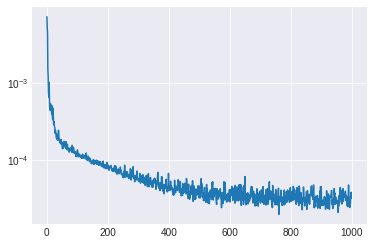

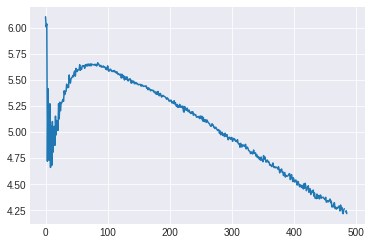

In [33]:
plt.plot(me_history.history['loss'])
plt.yscale('log')
plt.show()
plt.plot(me_history.history['weight-entropy'])
plt.show()

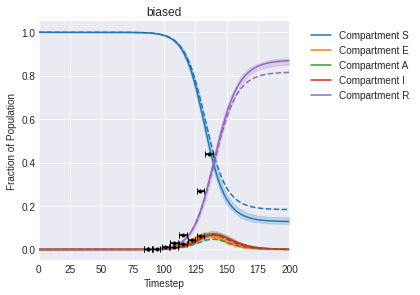

In [34]:
patch_number = 0
maxentep.traj_quantile(trajs[:,:,patch_number,:], weights=me_model.traj_weights,alpha=0.2, names=full_compartments)
plt.plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns_list[patch_number]):
    pf(plt, me_model.lambdas[i], color='k')
plt.tight_layout()
# plt.ylim(0,0.2)
# plt.xlim(0,75)
plt.title('biased')
plt.show()

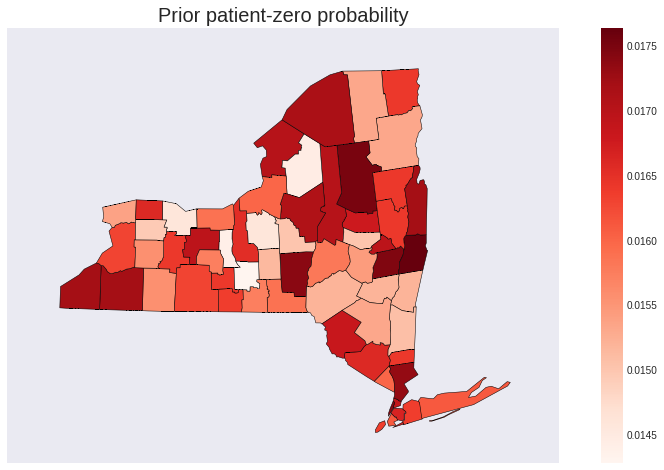

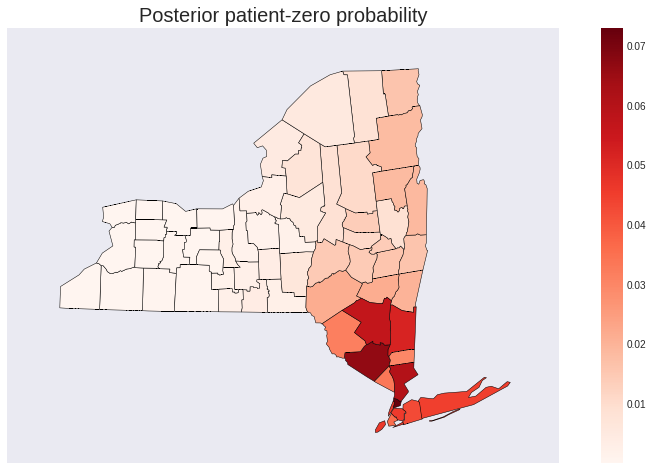

In [35]:
me_w = me_model.traj_weights
prior_exposed_patch = maxentep.exposed_finder(trajs)
posterior_exposed_prob = maxentep.weighted_exposed_prob_finder(prior_exposed_patch, M, weights = me_w)
maxentep.p0_map(prior_exposed_patch, M, weights = None, patch_names=patches, title = 'Prior patient-zero probability', fontsize=20, choropleth=True,
       geojson='counties_ny.geojson')
maxentep.p0_map(prior_exposed_patch, M, weights = me_w, title = 'Posterior patient-zero probability', patch_names=patches, fontsize=20
      , choropleth=True, geojson='counties_ny.geojson')

In [36]:
sorted(zip(prior_exposed_patch, patches), reverse=True)[:5]

[(61, 'Chenango County'),
 (60, 'Montgomery County'),
 (60, 'Columbia County'),
 (60, 'Clinton County'),
 (60, 'Chemung County')]

In [37]:
sorted(zip(posterior_exposed_prob, patches), reverse=True)[:5]

[(0.0729743275457493, 'Bronx County'),
 (0.06667174278852267, 'Orange County'),
 (0.06042301080280871, 'Westchester County'),
 (0.05682710895911053, 'Ulster County'),
 (0.051817504808010326, 'Dutchess County')]

## Algorithm 2

In [38]:
fit_param_model = maxentep.MetaParameterJoint(start_logits, mobility_matrix , tmat, name='unbiased_model',hypers = hyper_pram,  n_infectious_compartments=2)
fit_param_model.compile(tf.optimizers.SGD(1))

hme_model = maxentep.HyperMaxentModel(restraints, fit_param_model, model, reweight=False)
hme_model.compile(tf.keras.optimizers.SGD(learning_rate=1), 'mean_squared_error')

In [39]:
hme_history = hme_model.fit(
    N, final_batch_multiplier=batches, 
    outter_epochs=3, param_epochs=50, batch_size=N, epochs=100)

Epoch 1/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0685 - weight-entropy: 7.6246
Epoch 2/100
1/1 [==============================] - 0s 620us/step - loss: 0.0014 - weight-entropy: 7.0178
Epoch 3/100
1/1 [==============================] - 0s 588us/step - loss: 0.0014 - weight-entropy: 7.0200
Epoch 4/100
1/1 [==============================] - 0s 730us/step - loss: 0.0014 - weight-entropy: 7.0221
Epoch 5/100
1/1 [==============================] - 0s 605us/step - loss: 0.0014 - weight-entropy: 7.0241
Epoch 6/100
1/1 [==============================] - 0s 577us/step - loss: 0.0014 - weight-entropy: 7.0259
Epoch 7/100
1/1 [==============================] - 0s 559us/step - loss: 0.0014 - weight-entropy: 7.0276
Epoch 8/100
1/1 [==============================] - 0s 698us/step - loss: 0.0014 - weight-entropy: 7.0292
Epoch 9/100
1/1 [==============================] - 0s 550us/step - loss: 0.0014 - weight-entropy: 7.0307
Epoch 10/100
1/1 [==============================] - 0s 53

1/1 [==============================] - 0s 538us/step - loss: 0.0013 - weight-entropy: 7.0465
Epoch 73/100
1/1 [==============================] - 0s 599us/step - loss: 0.0013 - weight-entropy: 7.0465
Epoch 74/100
1/1 [==============================] - 0s 541us/step - loss: 0.0013 - weight-entropy: 7.0465
Epoch 75/100
1/1 [==============================] - 0s 604us/step - loss: 0.0013 - weight-entropy: 7.0465
Epoch 76/100
1/1 [==============================] - 0s 544us/step - loss: 0.0013 - weight-entropy: 7.0465
Epoch 77/100
1/1 [==============================] - 0s 529us/step - loss: 0.0013 - weight-entropy: 7.0465
Epoch 78/100
1/1 [==============================] - 0s 543us/step - loss: 0.0013 - weight-entropy: 7.0465
Epoch 79/100
1/1 [==============================] - 0s 581us/step - loss: 0.0013 - weight-entropy: 7.0465
Epoch 80/100
1/1 [==============================] - 0s 594us/step - loss: 0.0013 - weight-entropy: 7.0465
Epoch 81/100
1/1 [==============================] - 0s 569u

64/64 [==============================] - 0s 2ms/step - loss: 6.2003 - R-dist-dist_loss: 6.5415 - T-dist-dist_loss: -0.0023 - rho-dist-dist_loss: -0.2558 - beta-dist_loss: -0.0831
Epoch 28/50
64/64 [==============================] - 0s 2ms/step - loss: 6.2003 - R-dist-dist_loss: 6.5415 - T-dist-dist_loss: -0.0023 - rho-dist-dist_loss: -0.2558 - beta-dist_loss: -0.0831
Epoch 29/50
64/64 [==============================] - 0s 2ms/step - loss: 6.2003 - R-dist-dist_loss: 6.5415 - T-dist-dist_loss: -0.0023 - rho-dist-dist_loss: -0.2558 - beta-dist_loss: -0.0831
Epoch 30/50
64/64 [==============================] - 0s 2ms/step - loss: 6.2003 - R-dist-dist_loss: 6.5415 - T-dist-dist_loss: -0.0023 - rho-dist-dist_loss: -0.2558 - beta-dist_loss: -0.0831
Epoch 31/50
64/64 [==============================] - 0s 2ms/step - loss: 6.2003 - R-dist-dist_loss: 6.5415 - T-dist-dist_loss: -0.0023 - rho-dist-dist_loss: -0.2558 - beta-dist_loss: -0.0831
Epoch 32/50
64/64 [==============================] - 0s 2

1/1 [==============================] - 0s 555us/step - loss: 0.0012 - weight-entropy: 7.0610
Epoch 36/100
1/1 [==============================] - 0s 651us/step - loss: 0.0012 - weight-entropy: 7.0610
Epoch 37/100
1/1 [==============================] - 0s 638us/step - loss: 0.0012 - weight-entropy: 7.0611
Epoch 38/100
1/1 [==============================] - 0s 557us/step - loss: 0.0012 - weight-entropy: 7.0611
Epoch 39/100
1/1 [==============================] - 0s 537us/step - loss: 0.0012 - weight-entropy: 7.0611
Epoch 40/100
1/1 [==============================] - 0s 570us/step - loss: 0.0012 - weight-entropy: 7.0611
Epoch 41/100
1/1 [==============================] - 0s 541us/step - loss: 0.0012 - weight-entropy: 7.0611
Epoch 42/100
1/1 [==============================] - 0s 540us/step - loss: 0.0012 - weight-entropy: 7.0611
Epoch 43/100
1/1 [==============================] - 0s 531us/step - loss: 0.0012 - weight-entropy: 7.0611
Epoch 44/100
1/1 [==============================] - 0s 540u

64/64 [==============================] - 0s 2ms/step - loss: 6.2007 - R-dist-dist_loss: 6.5419 - T-dist-dist_loss: -0.0023 - rho-dist-dist_loss: -0.2558 - beta-dist_loss: -0.0831
Epoch 8/50
64/64 [==============================] - 0s 2ms/step - loss: 6.2007 - R-dist-dist_loss: 6.5419 - T-dist-dist_loss: -0.0023 - rho-dist-dist_loss: -0.2558 - beta-dist_loss: -0.0831
Epoch 9/50
64/64 [==============================] - 0s 2ms/step - loss: 6.2007 - R-dist-dist_loss: 6.5419 - T-dist-dist_loss: -0.0023 - rho-dist-dist_loss: -0.2558 - beta-dist_loss: -0.0831
Epoch 10/50
64/64 [==============================] - 0s 2ms/step - loss: 6.2007 - R-dist-dist_loss: 6.5419 - T-dist-dist_loss: -0.0023 - rho-dist-dist_loss: -0.2558 - beta-dist_loss: -0.0831
Epoch 11/50
64/64 [==============================] - 0s 2ms/step - loss: 6.2007 - R-dist-dist_loss: 6.5419 - T-dist-dist_loss: -0.0023 - rho-dist-dist_loss: -0.2558 - beta-dist_loss: -0.0831
Epoch 12/50
64/64 [==============================] - 0s 2ms

64/64 [==============================] - 0s 2ms/step - loss: 6.2007 - R-dist-dist_loss: 6.5419 - T-dist-dist_loss: -0.0023 - rho-dist-dist_loss: -0.2558 - beta-dist_loss: -0.0831
Epoch 50/50
64/64 [==============================] - 0s 2ms/step - loss: 6.2007 - R-dist-dist_loss: 6.5419 - T-dist-dist_loss: -0.0023 - rho-dist-dist_loss: -0.2558 - beta-dist_loss: -0.0831
Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 0.0087 - weight-entropy: 7.1393
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 7.0760
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 7.0791
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 7.0816
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 7.0812
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 7.0814
Epoch 7/100


8/8 [==============================] - 0s 2ms/step - loss: 9.6094e-04 - weight-entropy: 7.0570
Epoch 76/100
8/8 [==============================] - 0s 2ms/step - loss: 9.5773e-04 - weight-entropy: 7.0562
Epoch 77/100
8/8 [==============================] - 0s 2ms/step - loss: 9.5531e-04 - weight-entropy: 7.0564
Epoch 78/100
8/8 [==============================] - 0s 2ms/step - loss: 9.5331e-04 - weight-entropy: 7.0556
Epoch 79/100
8/8 [==============================] - 0s 2ms/step - loss: 9.4831e-04 - weight-entropy: 7.0557
Epoch 80/100
8/8 [==============================] - 0s 2ms/step - loss: 9.4270e-04 - weight-entropy: 7.0547
Epoch 81/100
8/8 [==============================] - 0s 2ms/step - loss: 9.4391e-04 - weight-entropy: 7.0551
Epoch 82/100
8/8 [==============================] - 0s 2ms/step - loss: 9.3815e-04 - weight-entropy: 7.0536
Epoch 83/100
8/8 [==============================] - 0s 2ms/step - loss: 9.4426e-04 - weight-entropy: 7.0535
Epoch 84/100
8/8 [=======================

In [40]:
hme_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), 'mean_squared_error') 
# hme_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), loss=ref_traj_loss)
hme_final_history = hme_model.fit(N, final_batch_multiplier=batches, outter_epochs=1, batch_size=N, epochs=500)

Epoch 1/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0143 - weight-entropy: 7.3001
Epoch 2/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 6.9197
Epoch 3/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 6.8577
Epoch 4/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0025 - weight-entropy: 6.8542
Epoch 5/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 6.8711
Epoch 6/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 6.8992
Epoch 7/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 6.9326
Epoch 8/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 6.9644
Epoch 9/500
8/8 [==============================] - 0s 2ms/step - loss: 7.9927e-04 - weight-entropy: 6.9861
Epoch 10/500
8/8 [==============================] - 0s 2ms/step - los

8/8 [==============================] - 0s 2ms/step - loss: 3.7974e-04 - weight-entropy: 6.6228
Epoch 72/500
8/8 [==============================] - 0s 2ms/step - loss: 3.8064e-04 - weight-entropy: 6.6268
Epoch 73/500
8/8 [==============================] - 0s 2ms/step - loss: 3.7431e-04 - weight-entropy: 6.6195
Epoch 74/500
8/8 [==============================] - 0s 2ms/step - loss: 3.6976e-04 - weight-entropy: 6.6078
Epoch 75/500
8/8 [==============================] - 0s 2ms/step - loss: 3.7526e-04 - weight-entropy: 6.6063
Epoch 76/500
8/8 [==============================] - 0s 2ms/step - loss: 3.7461e-04 - weight-entropy: 6.6019
Epoch 77/500
8/8 [==============================] - 0s 2ms/step - loss: 3.6892e-04 - weight-entropy: 6.5919
Epoch 78/500
8/8 [==============================] - 0s 2ms/step - loss: 3.7153e-04 - weight-entropy: 6.5917
Epoch 79/500
8/8 [==============================] - 0s 2ms/step - loss: 4.0650e-04 - weight-entropy: 6.5870
Epoch 80/500
8/8 [=======================

8/8 [==============================] - 0s 2ms/step - loss: 3.1245e-04 - weight-entropy: 6.4089
Epoch 147/500
8/8 [==============================] - 0s 2ms/step - loss: 3.1258e-04 - weight-entropy: 6.4146
Epoch 148/500
8/8 [==============================] - 0s 2ms/step - loss: 3.0537e-04 - weight-entropy: 6.4298
Epoch 149/500
8/8 [==============================] - 0s 2ms/step - loss: 3.1776e-04 - weight-entropy: 6.4193
Epoch 150/500
8/8 [==============================] - 0s 2ms/step - loss: 3.2390e-04 - weight-entropy: 6.4232
Epoch 151/500
8/8 [==============================] - 0s 2ms/step - loss: 3.1660e-04 - weight-entropy: 6.4107
Epoch 152/500
8/8 [==============================] - 0s 2ms/step - loss: 3.1197e-04 - weight-entropy: 6.4046
Epoch 153/500
8/8 [==============================] - 0s 2ms/step - loss: 3.3733e-04 - weight-entropy: 6.4248
Epoch 154/500
8/8 [==============================] - 0s 2ms/step - loss: 3.1324e-04 - weight-entropy: 6.4267
Epoch 155/500
8/8 [==============

8/8 [==============================] - 0s 2ms/step - loss: 3.2377e-04 - weight-entropy: 6.4072
Epoch 222/500
8/8 [==============================] - 0s 2ms/step - loss: 3.0226e-04 - weight-entropy: 6.3922
Epoch 223/500
8/8 [==============================] - 0s 2ms/step - loss: 3.3329e-04 - weight-entropy: 6.4123
Epoch 224/500
8/8 [==============================] - 0s 2ms/step - loss: 3.0853e-04 - weight-entropy: 6.4141
Epoch 225/500
8/8 [==============================] - 0s 2ms/step - loss: 2.9381e-04 - weight-entropy: 6.4008
Epoch 226/500
8/8 [==============================] - 0s 2ms/step - loss: 2.9798e-04 - weight-entropy: 6.3931
Epoch 227/500
8/8 [==============================] - 0s 2ms/step - loss: 2.8628e-04 - weight-entropy: 6.3973
Epoch 228/500
8/8 [==============================] - 0s 2ms/step - loss: 3.2044e-04 - weight-entropy: 6.4128
Epoch 229/500
8/8 [==============================] - 0s 2ms/step - loss: 2.7120e-04 - weight-entropy: 6.4086
Epoch 230/500
8/8 [==============

8/8 [==============================] - 0s 2ms/step - loss: 2.8314e-04 - weight-entropy: 6.4006
Epoch 297/500
8/8 [==============================] - 0s 2ms/step - loss: 2.6967e-04 - weight-entropy: 6.3924
Epoch 298/500
8/8 [==============================] - 0s 2ms/step - loss: 2.7474e-04 - weight-entropy: 6.3847
Epoch 299/500
8/8 [==============================] - 0s 2ms/step - loss: 2.6766e-04 - weight-entropy: 6.3857
Epoch 300/500
8/8 [==============================] - 0s 2ms/step - loss: 2.7094e-04 - weight-entropy: 6.3730
Epoch 301/500
8/8 [==============================] - 0s 2ms/step - loss: 2.5718e-04 - weight-entropy: 6.3786
Epoch 302/500
8/8 [==============================] - 0s 2ms/step - loss: 2.8357e-04 - weight-entropy: 6.3939
Epoch 303/500
8/8 [==============================] - 0s 2ms/step - loss: 2.7946e-04 - weight-entropy: 6.3965
Epoch 304/500
8/8 [==============================] - 0s 2ms/step - loss: 2.6025e-04 - weight-entropy: 6.3878
Epoch 305/500
8/8 [==============

8/8 [==============================] - 0s 2ms/step - loss: 2.4011e-04 - weight-entropy: 6.3486
Epoch 372/500
8/8 [==============================] - 0s 2ms/step - loss: 2.5572e-04 - weight-entropy: 6.3614
Epoch 373/500
8/8 [==============================] - 0s 2ms/step - loss: 2.3589e-04 - weight-entropy: 6.3584
Epoch 374/500
8/8 [==============================] - 0s 2ms/step - loss: 2.4042e-04 - weight-entropy: 6.3466
Epoch 375/500
8/8 [==============================] - 0s 2ms/step - loss: 2.6478e-04 - weight-entropy: 6.3473
Epoch 376/500
8/8 [==============================] - 0s 2ms/step - loss: 2.2588e-04 - weight-entropy: 6.3531
Epoch 377/500
8/8 [==============================] - 0s 2ms/step - loss: 3.0909e-04 - weight-entropy: 6.3872
Epoch 378/500
8/8 [==============================] - 0s 2ms/step - loss: 2.5672e-04 - weight-entropy: 6.3539
Epoch 379/500
8/8 [==============================] - 0s 2ms/step - loss: 2.6440e-04 - weight-entropy: 6.3517
Epoch 380/500
8/8 [==============

8/8 [==============================] - 0s 2ms/step - loss: 2.4417e-04 - weight-entropy: 6.3187
Epoch 447/500
8/8 [==============================] - 0s 2ms/step - loss: 2.2359e-04 - weight-entropy: 6.3153
Epoch 448/500
8/8 [==============================] - 0s 2ms/step - loss: 2.4660e-04 - weight-entropy: 6.3191
Epoch 449/500
8/8 [==============================] - 0s 2ms/step - loss: 2.5954e-04 - weight-entropy: 6.3396
Epoch 450/500
8/8 [==============================] - 0s 2ms/step - loss: 2.6434e-04 - weight-entropy: 6.3434
Epoch 451/500
8/8 [==============================] - 0s 2ms/step - loss: 2.2217e-04 - weight-entropy: 6.3199
Epoch 452/500
8/8 [==============================] - 0s 2ms/step - loss: 2.3303e-04 - weight-entropy: 6.3190
Epoch 453/500
8/8 [==============================] - 0s 2ms/step - loss: 2.4261e-04 - weight-entropy: 6.3370
Epoch 454/500
8/8 [==============================] - 0s 2ms/step - loss: 2.3031e-04 - weight-entropy: 6.3210
Epoch 455/500
8/8 [==============

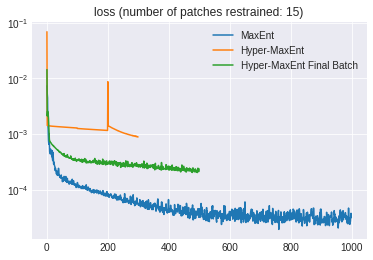

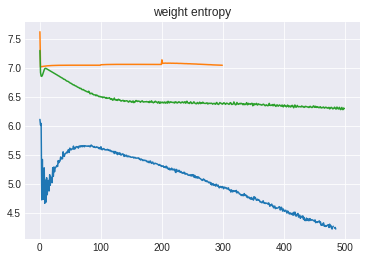

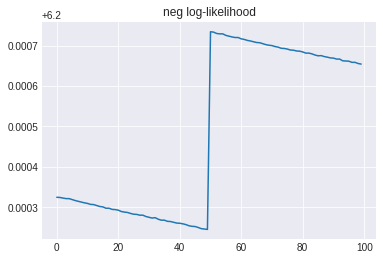

In [41]:
plt.plot(me_history.history['loss'],label='MaxEnt')
plt.plot(hme_history.history['loss'],label='Hyper-MaxEnt')
plt.plot(hme_final_history.history['loss'],label='Hyper-MaxEnt Final Batch')
plt.title('loss (number of patches restrained: {})'.format(len(restrained_patches)))
plt.yscale('log')
plt.legend()
plt.savefig('loss_{}_restraints'.format(len(restrained_patches)),dpi= 300)
plt.show()

plt.plot(me_history.history['weight-entropy'])
plt.plot(hme_history.history['weight-entropy'])
plt.plot(hme_final_history.history['weight-entropy'])
plt.title('weight entropy')
plt.show()

plt.plot(hme_history.history['prior-loss'])
plt.title('neg log-likelihood')
plt.show()

# plt.plot(hme_history.history['loss-from-ref'])
# plt.show()

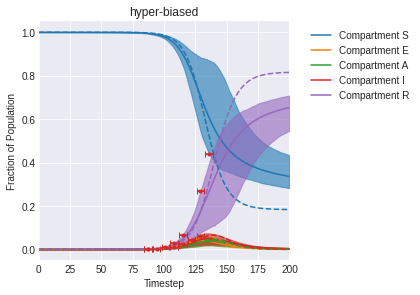

In [42]:
patch_number = 0
maxentep.traj_quantile(hme_model.trajs[:,:,patch_number,:], weights=hme_model.traj_weights, names=full_compartments)
plt.plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns_list[patch_number]):
    pf(plt, hme_model.lambdas[i], color='C3')
plt.tight_layout()
# plt.ylim(0,0.2)
# plt.xlim(0,75)
plt.title('hyper-biased')
plt.show()


## Direct Regression of Model

In [43]:
T = tmat.value
start = np.zeros((M, C))
start[0,1] = 1e-6
infect = maxentep.ContactInfectionLayer(np.array([hyper_pram.beta_start,hyper_pram.beta_start]), infections_compartments, area=area)
# make "agreement" function
def agreement(traj, rs=restraints):
    s = 0
    for r in rs:
        s += r(traj[0])**2
    return s
rmodel = maxentep.TrainableMetaModel(start, mobility_matrix, T, infect, Time, agreement, populations=population)

In [44]:
rmodel.compile(optimizer=tf.keras.optimizers.Nadam(0.01))
utraj = rmodel.get_traj()
rmodel.fit(150)
rtraj = rmodel.get_traj()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().
150/150 [==============================] - 20s 135ms/step - loss: 1.6334 - output_2_loss: 1.6334


## Visualizing results

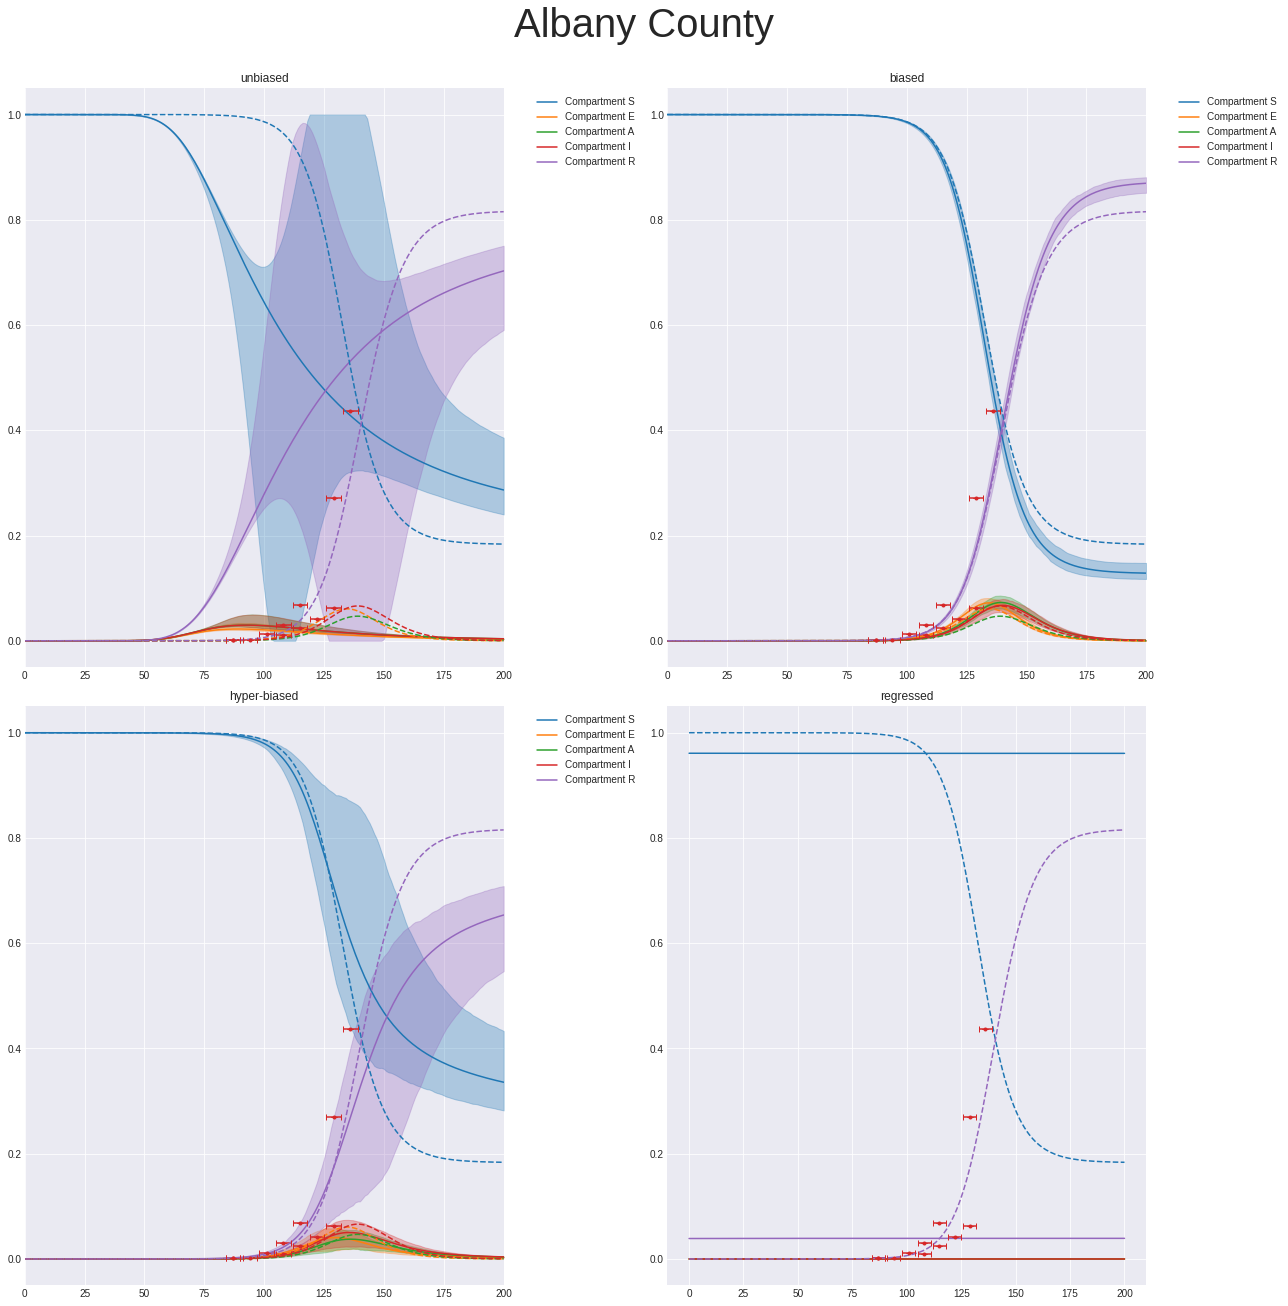

In [45]:
patch_number = 0
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18,18))
fig.suptitle('{}'.format(patches[patch_number]), fontsize=40,y=1.005)

axs[0,0].set_title('unbiased')
maxentep.traj_quantile(trajs[:,:,patch_number,:], names=full_compartments, ax=axs[0,0],alpha = 0.3)
axs[0,0].plot(ref_traj[p,:,patch_number,:], linestyle='--')

for i,pf in enumerate(plot_fxns_list[patch_number]):
    pf(axs[0,0], me_model.lambdas[i], color='C3')
plt.tight_layout()

axs[0,1].set_title('biased')
maxentep.traj_quantile(trajs[:,:,patch_number,:], weights=me_model.traj_weights, names=full_compartments,alpha = 0.3, ax=axs[0,1])
axs[0,1].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns_list[patch_number]):
    pf(axs[0,1], me_model.lambdas[i], color='C3')
plt.tight_layout()

axs[1,0].set_title('hyper-biased')
maxentep.traj_quantile(hme_model.trajs[:,:,patch_number,:], alpha = 0.3,weights=hme_model.traj_weights, names=full_compartments, ax=axs[1,0])
axs[1,0].plot(ref_traj[p,:,patch_number,:], linestyle='--')
for i,pf in enumerate(plot_fxns_list[patch_number]):
    pf(axs[1,0], hme_model.lambdas[i], color='C3')
plt.tight_layout()

axs[1,1].set_title('regressed')
axs[1,1].plot(rtraj[0,:,patch_number,:])
axs[1,1].plot(ref_traj[p,:,patch_number,0], linestyle='--',color='C0')
axs[1,1].plot(ref_traj[p,:,patch_number,4], linestyle='--',color='C4')
for i,pf in enumerate(plot_fxns_list[patch_number]):
    pf(axs[1,1], 1, color='C3')

    
plt.tight_layout()
# plt.savefig('compare_Albany.png', dpi = 300)
plt.show()
plt.close()

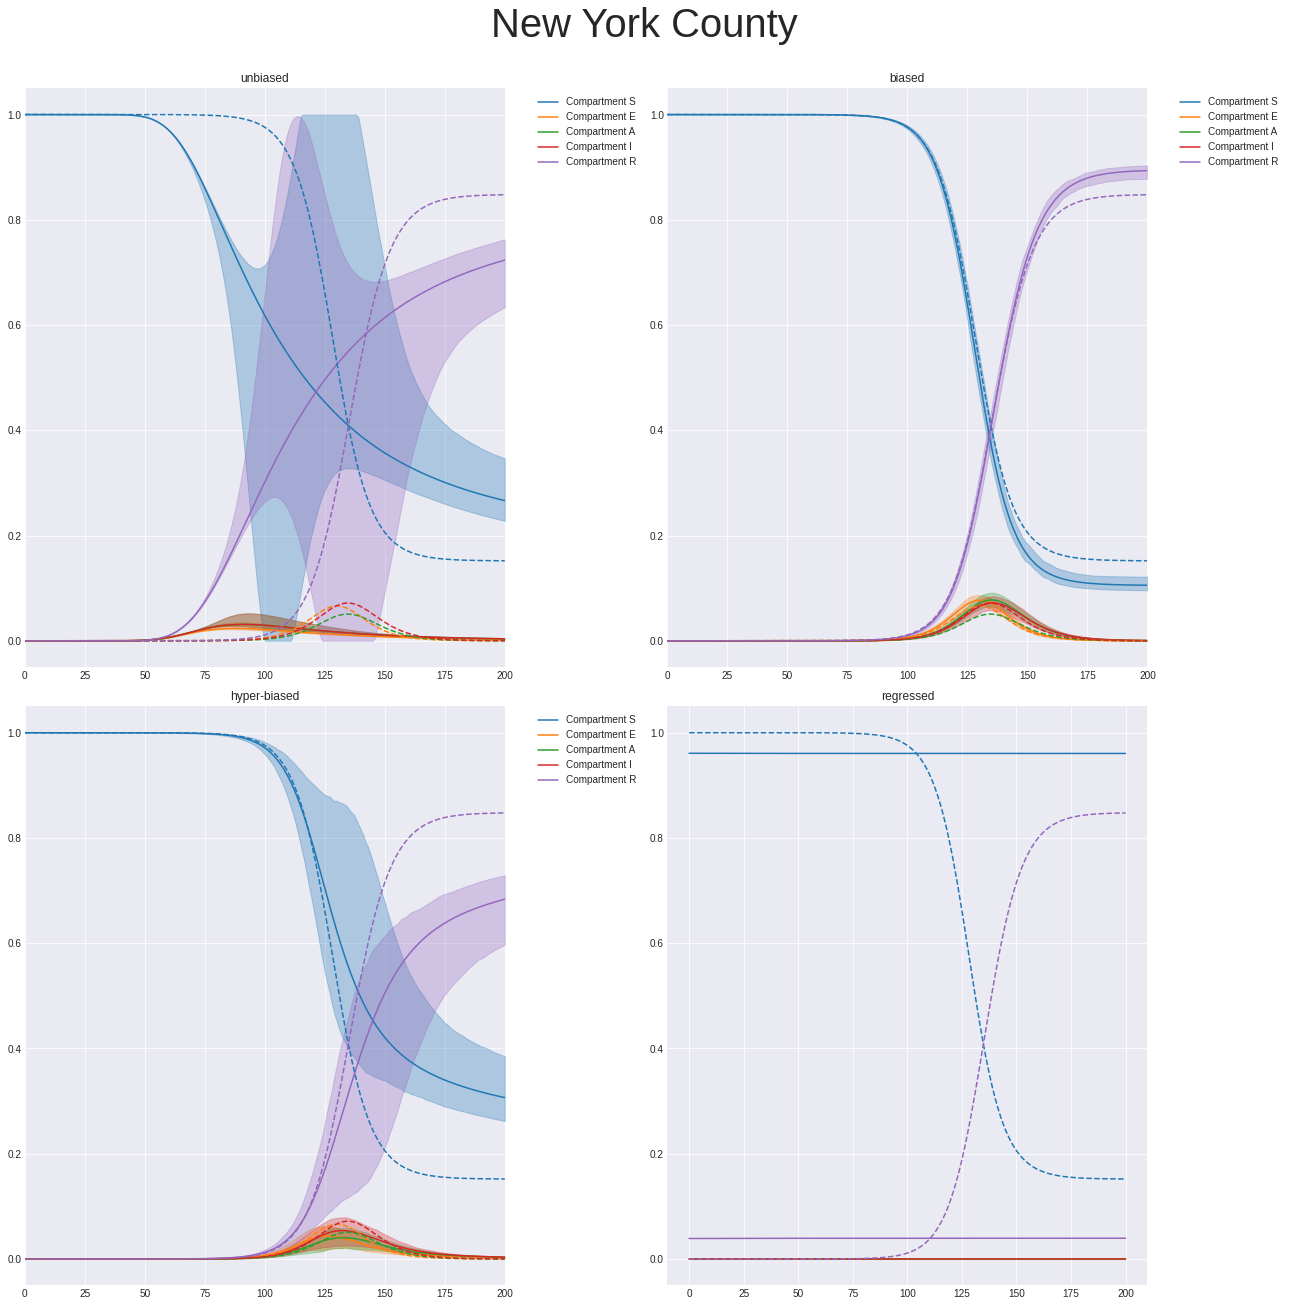

In [46]:
patch_number = 30
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18,18))
fig.suptitle('{}'.format(patches[patch_number]), fontsize=40,y=1.005)

axs[0,0].set_title('unbiased')
maxentep.traj_quantile(trajs[:,:,patch_number,:], names=full_compartments, ax=axs[0,0],alpha = 0.3)
axs[0,0].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# ax[0,0].tick_params(color='green', labelcolor='green')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
# for i,pf in enumerate(plot_fxns):
#     pf(axs[0,0], me_model.lambdas[i], color='C3')
# plt.tight_layout()

axs[0,1].set_title('biased')
maxentep.traj_quantile(trajs[:,:,patch_number,:], weights=me_model.traj_weights, alpha = 0.3,names=full_compartments, ax=axs[0,1])
axs[0,1].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
# for i,pf in enumerate(plot_fxns):
#     pf(axs[0,1], me_model.lambdas[i], color='C3')
# plt.tight_layout()

axs[1,0].set_title('hyper-biased')
maxentep.traj_quantile(hme_model.trajs[:,:,patch_number,:], weights=hme_model.traj_weights, alpha = 0.3,names=full_compartments, ax=axs[1,0])
axs[1,0].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# for i,pf in enumerate(plot_fxns):
#     pf(axs[1,0], hme_model.lambdas[i], color='C3')
# plt.tight_layout()

axs[1,1].set_title('regressed')
axs[1,1].plot(rtraj[0,:,patch_number,:])
axs[1,1].plot(ref_traj[p,:,patch_number,0], linestyle='--',color='C0')
axs[1,1].plot(ref_traj[p,:,patch_number,4], linestyle='--',color='C4')
# for i,pf in enumerate(plot_fxns):
#     pf(axs[1,1], 1, color='C3')

plt.tight_layout()
# plt.savefig('compare_NY.png', dpi = 300)
plt.show()
plt.close()

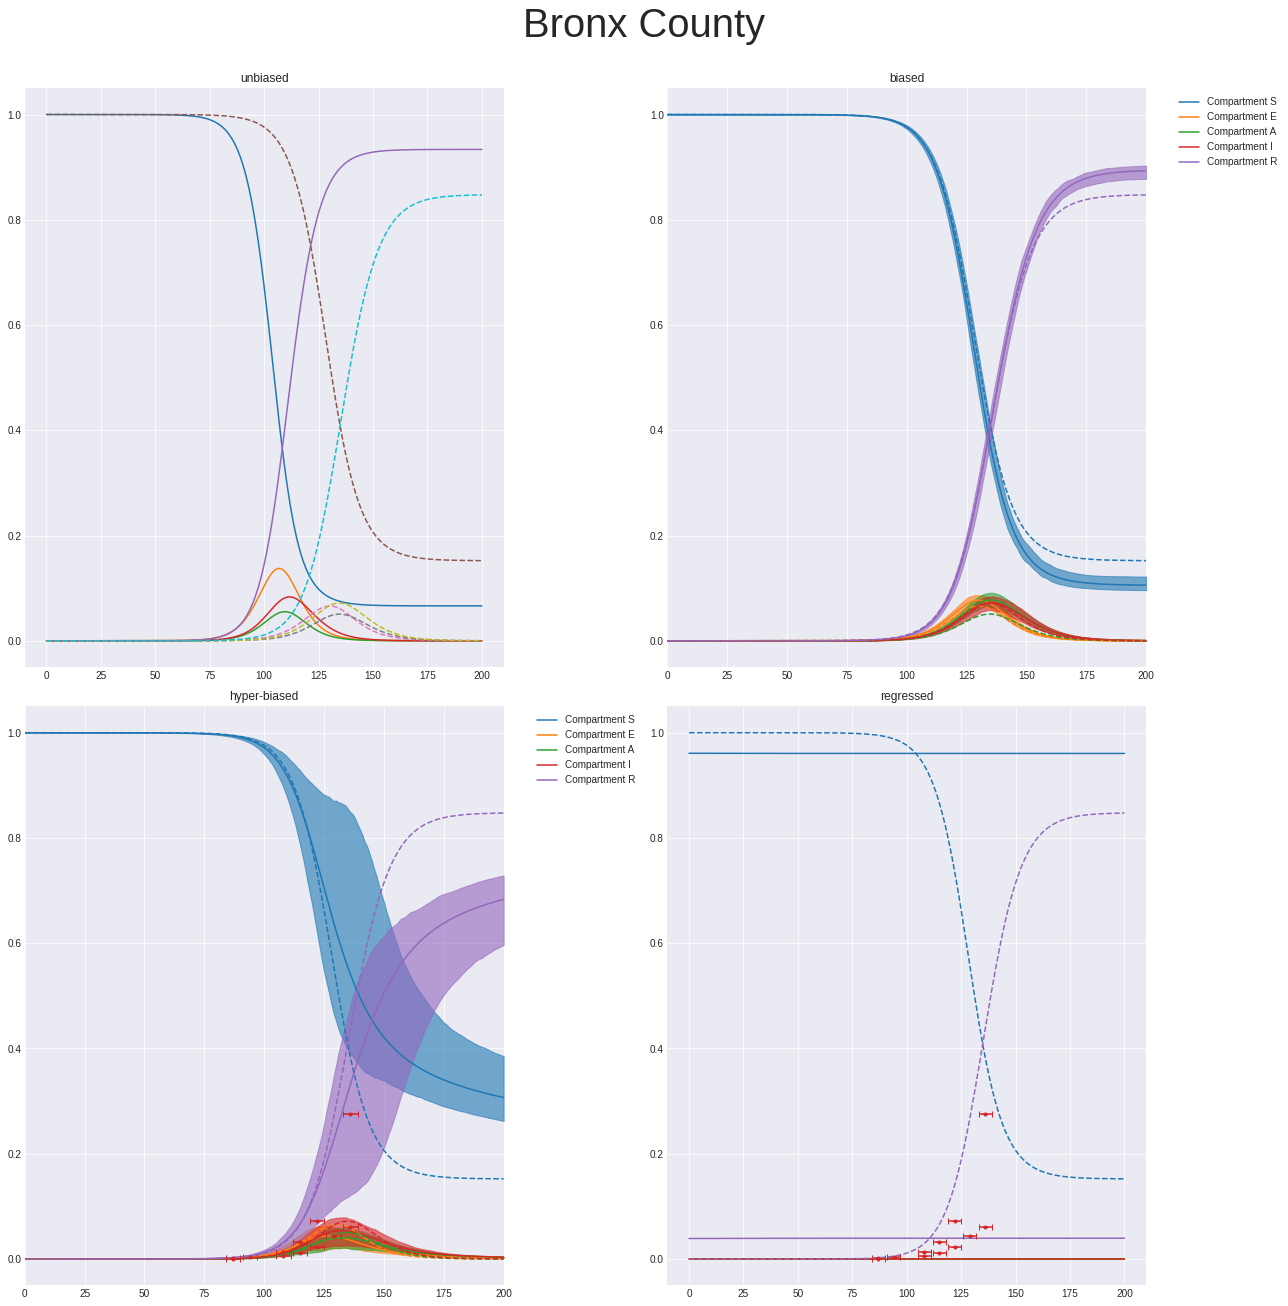

(1, 201, 62, 5)


In [47]:
patch_number = 2
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18,18))
fig.suptitle('{}'.format(patches[patch_number]), fontsize=40,y=1.005)

axs[0,0].set_title('unbiased')
axs[0,0].plot(trajs[0,:,patch_number,:])
axs[0,0].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
# for i,pf in enumerate(plot_fxns_list[patch_number]):
#     pf(axs[0,0], me_model.lambdas[i], color='C3')
# plt.tight_layout()

axs[0,1].set_title('biased')
maxentep.traj_quantile(trajs[:,:,patch_number,:], weights=me_model.traj_weights, names=full_compartments, ax=axs[0,1])
axs[0,1].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
# for i,pf in enumerate(plot_fxns_list[patch_number]):
#     pf(axs[0,1], me_model.lambdas[i], color='C3')
# plt.tight_layout()

axs[1,0].set_title('hyper-biased')
maxentep.traj_quantile(hme_model.trajs[:,:,patch_number,:], weights=hme_model.traj_weights, names=full_compartments, ax=axs[1,0])
axs[1,0].plot(ref_traj[p,:,patch_number,:], linestyle='--')
for i,pf in enumerate(plot_fxns_list[patch_number]):
    pf(axs[1,0], hme_model.lambdas[i], color='C3')
plt.tight_layout()

axs[1,1].set_title('regressed')
axs[1,1].plot(rtraj[0,:,patch_number,:])
axs[1,1].plot(ref_traj[p,:,patch_number,0], linestyle='--',color='C0')
axs[1,1].plot(ref_traj[p,:,patch_number,4], linestyle='--',color='C4')
for i,pf in enumerate(plot_fxns_list[patch_number]):
    pf(axs[1,1], 1, color='C3')

plt.tight_layout()
plt.savefig('compare_Livingston.png', dpi = 300)
plt.show()
print (ref_traj.shape)

In [48]:
weights_dict = {'unbiased':None, 'biased':me_model.traj_weights, 'hyper-biased':hme_model.traj_weights, 'regression':None }
from matplotlib.patches import Patch
print (restrained_patches)
def compare_patches(ref_traj,trajs,weights_dict, method ,*args, figsize=(18, 18), patch_names=None, ** kw_args):
    '''does traj_quantile for trajectories of shape [ntrajs, time, patches, compartments]
    '''
    weights = weights_dict[method]
#     p = 1
    NP = trajs.shape[2]
    nrow = int(np.floor(np.sqrt(NP)))
    ncol = int(np.ceil(NP / nrow))
    print(f'Plotting {NP} patches in a {nrow} x {ncol} grid')
    fig, ax = plt.subplots(nrow, ncol, sharex=True,
                           sharey=True, figsize=figsize)
    if method =='unbiased':
        fig.suptitle('{}'.format(method), fontsize=30,y=1.03)
    else:
        fig.suptitle('{} (Patches restrained: {}, Points restrained in each patch: {}, Compartments restrained: {})'
                     .format(method,len(restrained_patches),npoints*number_of_restrained_compartments,restrained_compartments_names)
                     , fontsize=26,y=1.03)
    for i in range(nrow):
        for j in range(ncol):
            if i * ncol + j == NP:
                break
#             traj_quantile(trajs[:,:,i * ncol + j,:], weights=weights, names=full_compartments, ax=axs[0,i])
            ax[i,j].plot(ref_traj[p,:,i * ncol + j,:], linestyle='--')
            if method == 'unbiased':
                traj_quantile(trajs[:, :, i * ncol + j, :], *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'biased':
                traj_quantile(trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'hyper-biased':
                traj_quantile(hme_model.trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'regression':
                ax[i,j].plot(rtraj[p,:,i * ncol + j,:])
#             ax[i, j].set_ylim(0, 1)
            if i * ncol + j in restrained_patches and method != 'unbiased':
                for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i * ncol + j)]):
                    pf(ax[i,j],0, color='C3')
                ax[i,j].spines['bottom'].set_color('y')
                ax[i,j].spines['top'].set_color('y') 
                ax[i,j].spines['right'].set_color('y')
                ax[i,j].spines['left'].set_color('y')
                ax[i,j].spines['left'].set_linewidth(2)
                ax[i,j].spines['top'].set_linewidth(2)
                ax[i,j].spines['right'].set_linewidth(2)
                ax[i,j].spines['bottom'].set_linewidth(2)
#             plt.tight_layout()
            if patch_names is None:
                ax[i, j].text(trajs.shape[1] // 2, 0.8,
                              f'Patch {i * ncol + j}')
            else:
                patch_names = patch_names
                ax[i, j].set_title(patch_names[i * ncol + j])

            if j == 0 and i == nrow // 2:
                ax[i, j].set_ylabel('Fraction')
            if i == nrow - 1 and j == ncol // 2:
                ax[i, j].set_xlabel('Time')
    plt.tight_layout()


[40 48 27  9 25 58 10 50 56  6 22 20  4  3 41]


Plotting 62 patches in a 7 x 9 grid


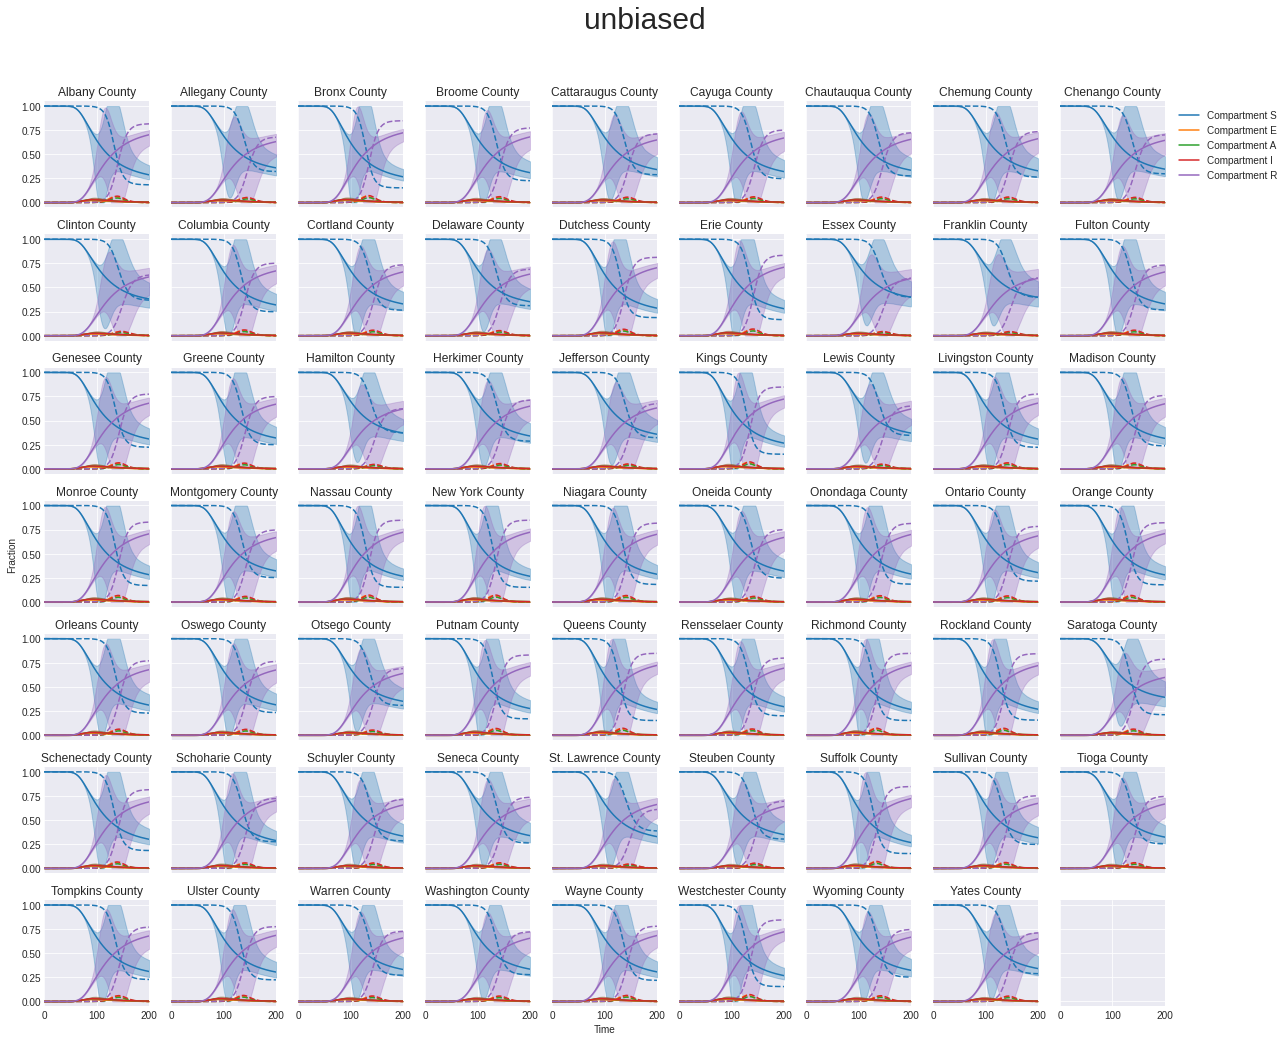

In [49]:
compare_patches(ref_traj,trajs,weights_dict,'unbiased', patch_names = patches, figsize=(18, 14), alpha=0.3, names=full_compartments)
plt.tight_layout()
plt.savefig('compare_unbiased.png',dpi=300)
# (ref_traj, trajs,weights_dict,'biased',patch_names = patches)

Plotting 62 patches in a 7 x 9 grid


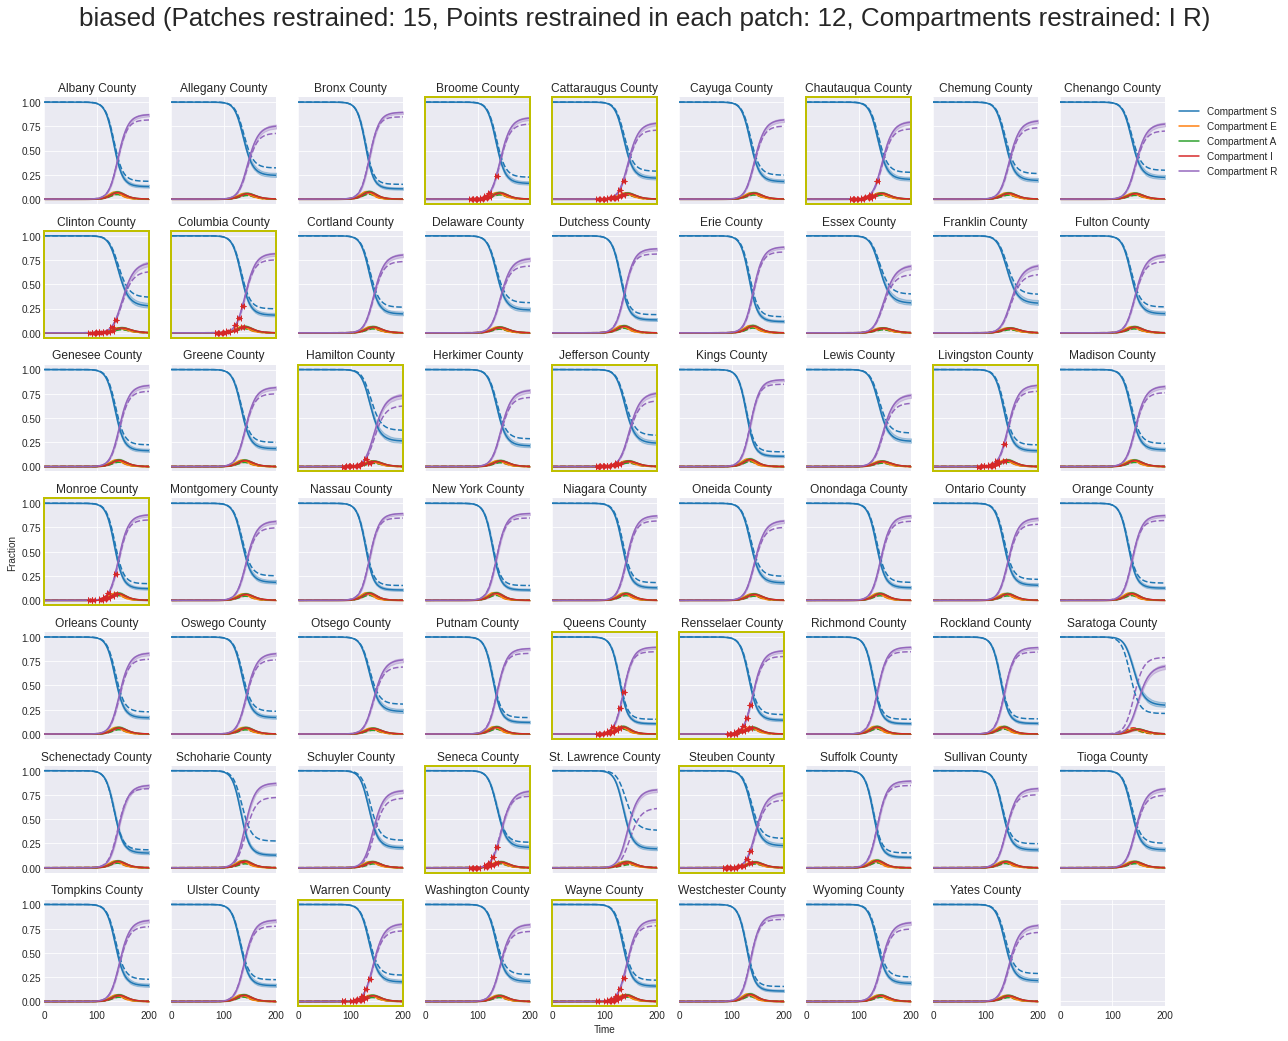

In [50]:
compare_patches(ref_traj,trajs,weights_dict,'biased', patch_names = patches, figsize=(18, 14), alpha=0.3, names=full_compartments)
plt.tight_layout()
plt.savefig('compare_biased_{}_restrained_{}.png'.format(len(restrained_patches),restrained_compartments_names),dpi=300)
# (ref_traj, trajs,weights_dict,'biased',patch_names = patches)

Plotting 62 patches in a 7 x 9 grid


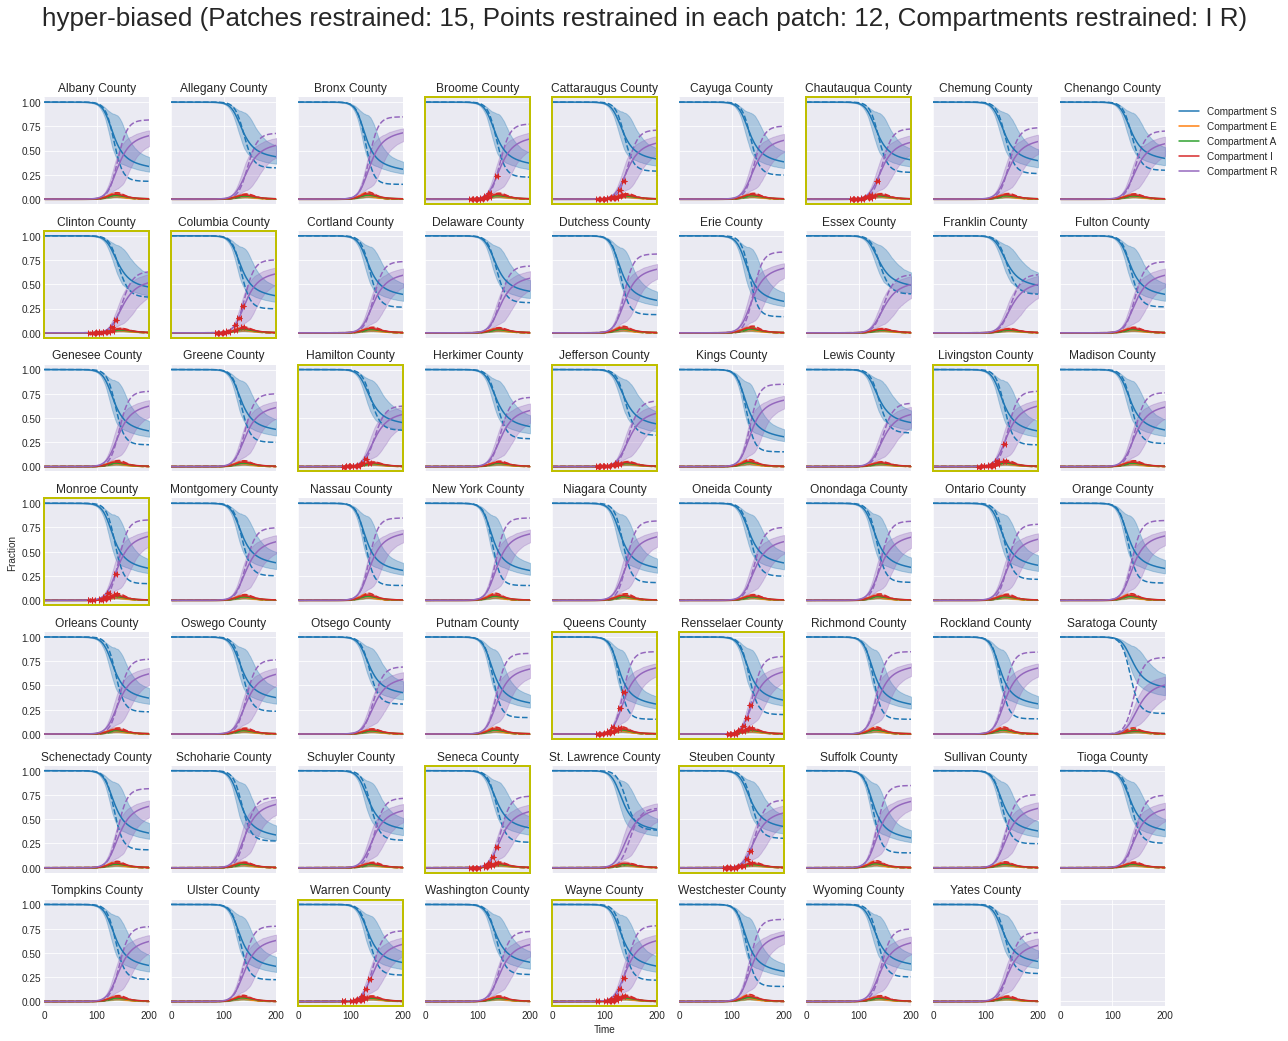

In [51]:
compare_patches(ref_traj,hme_model.trajs,weights_dict,'hyper-biased', patch_names = patches, figsize=(18, 14), alpha=0.3, names=full_compartments)
plt.tight_layout()
plt.savefig('compare_hyper_{}_restrained_{}.png'.format(len(restrained_patches),restrained_compartments_names),dpi=300)

In [52]:
weight_hyper = weights_dict['hyper-biased']
# weight_hyper /=np.sum(weight_hyper)
# mtrajs_patch = np.sum(trajs[:,:,0,:] * weight_hyper[:, np.newaxis, np.newaxis], axis=0)
# print (trajs.shape)
# print (mtrajs_patch.shape)
# print (trajs.shape[2], trajs.shape[-1])
def mean_traj(trajs,weights=None):
    Time = trajs.shape[1]
    c = trajs.shape[-1]
    M = trajs.shape[2]
    if weights is None:
        w = np.ones(trajs.shape[0])
    else:
        w = weights
    w /= np.sum(w)
    mtrajs_counties = np.empty([Time,M,c])
    for i in range(M):
        mtrajs_counties[:,i,:] = np.sum(trajs[:,:,i,:] * w[:, np.newaxis, np.newaxis], axis=0)
    mtrajs = np.sum(mtrajs_counties*population_fraction[np.newaxis, :, np.newaxis],axis=1)
    return mtrajs

    
mtrajs_hyper_biased = mean_traj(hme_model.trajs,weights = weights_dict['hyper-biased'])



mtrajs_biased = mean_traj(trajs,weights = weights_dict['biased'])
mtrajs_unbiased = mean_traj(trajs)
# REF = ref_traj[p,:,:,:]
# REF = np.expand_dims(REF,axis=0)
mref_traj = mean_traj(ref_traj)


mref_traj = mref_traj[:,:5]

loss_unbiased = np.mean((mref_traj- mtrajs_unbiased)**2)
loss_biased = np.mean((mref_traj- mtrajs_biased)**2)
loss_hyper_biased = np.mean((mref_traj- mtrajs_hyper_biased)**2)



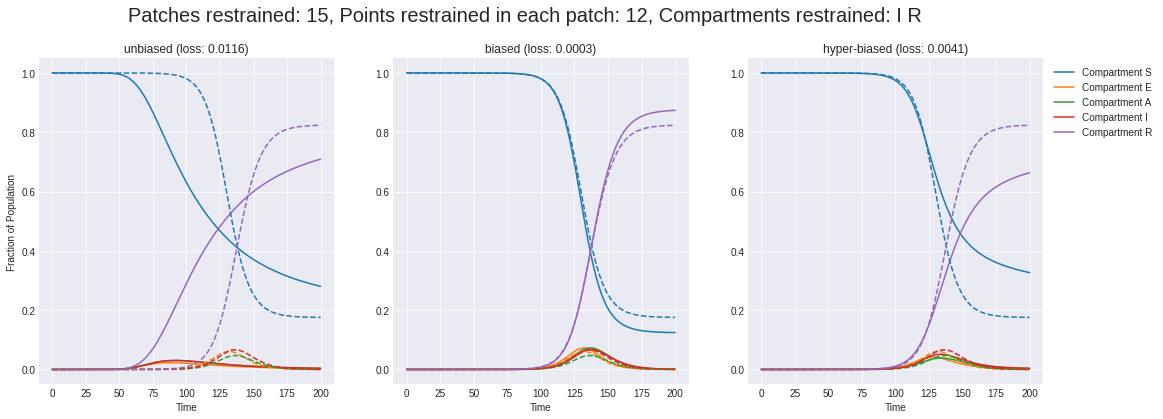

0.9999988556046202


In [53]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18,6))
fig.suptitle('Patches restrained: {}, Points restrained in each patch: {}, Compartments restrained: {}'
             .format(len(restrained_patches),npoints*number_of_restrained_compartments,restrained_compartments_names), fontsize=20,y=1.00)

axs[0].set_title('unbiased (loss: {})'.format(np.round(loss_unbiased,4)))
axs[1].set_title('biased (loss: {})'.format(np.round(loss_biased,4)))
axs[2].set_title('hyper-biased (loss: {})'.format(np.round(loss_hyper_biased,4)))
for i in range(mref_traj.shape[-1]):
    axs[0].plot(range(Time),mtrajs_unbiased[:,i],color=f'C{i}',label=f'Compartment {full_compartments[i]}')
    axs[1].plot(range(Time),mtrajs_biased[:,i],color=f'C{i}',label=f'Compartment {full_compartments[i]}')
    axs[2].plot(range(Time),mtrajs_hyper_biased[:,i],color=f'C{i}',label=f'Compartment {full_compartments[i]}')

axs[0].plot(mref_traj,linestyle='--')
axs[1].plot(mref_traj,linestyle='--')
axs[2].plot(mref_traj,linestyle='--')
axs[2].legend(bbox_to_anchor=(1.4, 1))
plt.setp(axs[:], xlabel='Time')
plt.setp(axs[0], ylabel='Fraction of Population')

# plt.tight_layout()
plt.savefig('compare_means_restraints_{}{}.png'.format(len(restrained_patches),restrained_compartments_names),dpi=300)
plt.show()
print (np.sum(mtrajs_biased[-1]))

In [54]:
Loss = np.mean((mref_traj- mtrajs_unbiased)**2)
print (Loss)

# print(end - start)

0.011560117852664014


Plotting 62 patches in a 7 x 9 grid


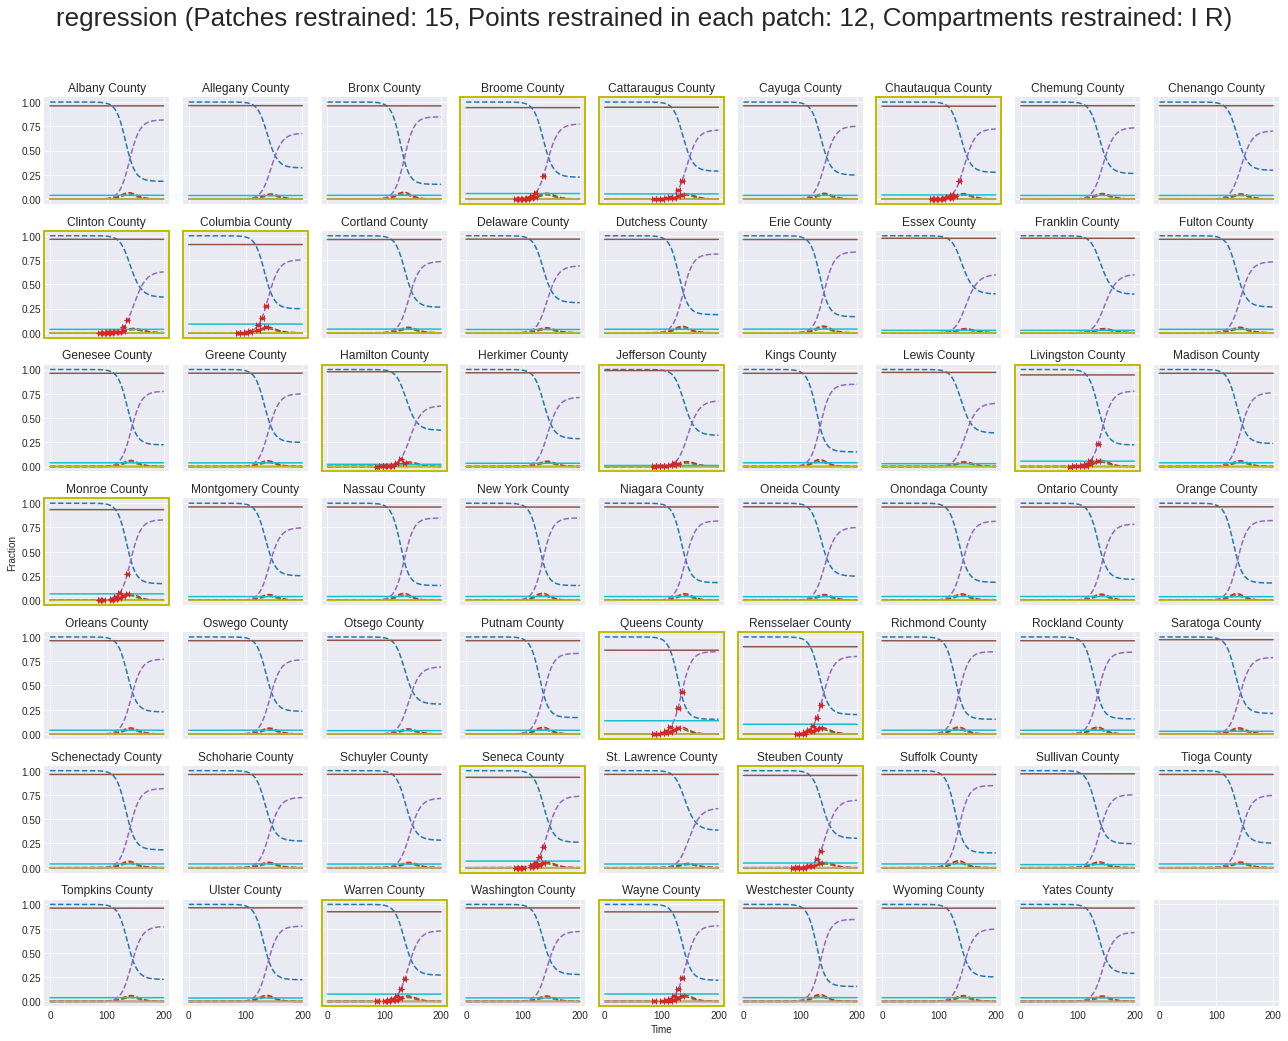

In [55]:
compare_patches(ref_traj,trajs,weights_dict,'regression', patch_names = patches, figsize=(18, 14), alpha=0.3, names=full_compartments)
plt.tight_layout()
plt.savefig('compare_regression.png',dpi=300)


# Parameter posterior distributions

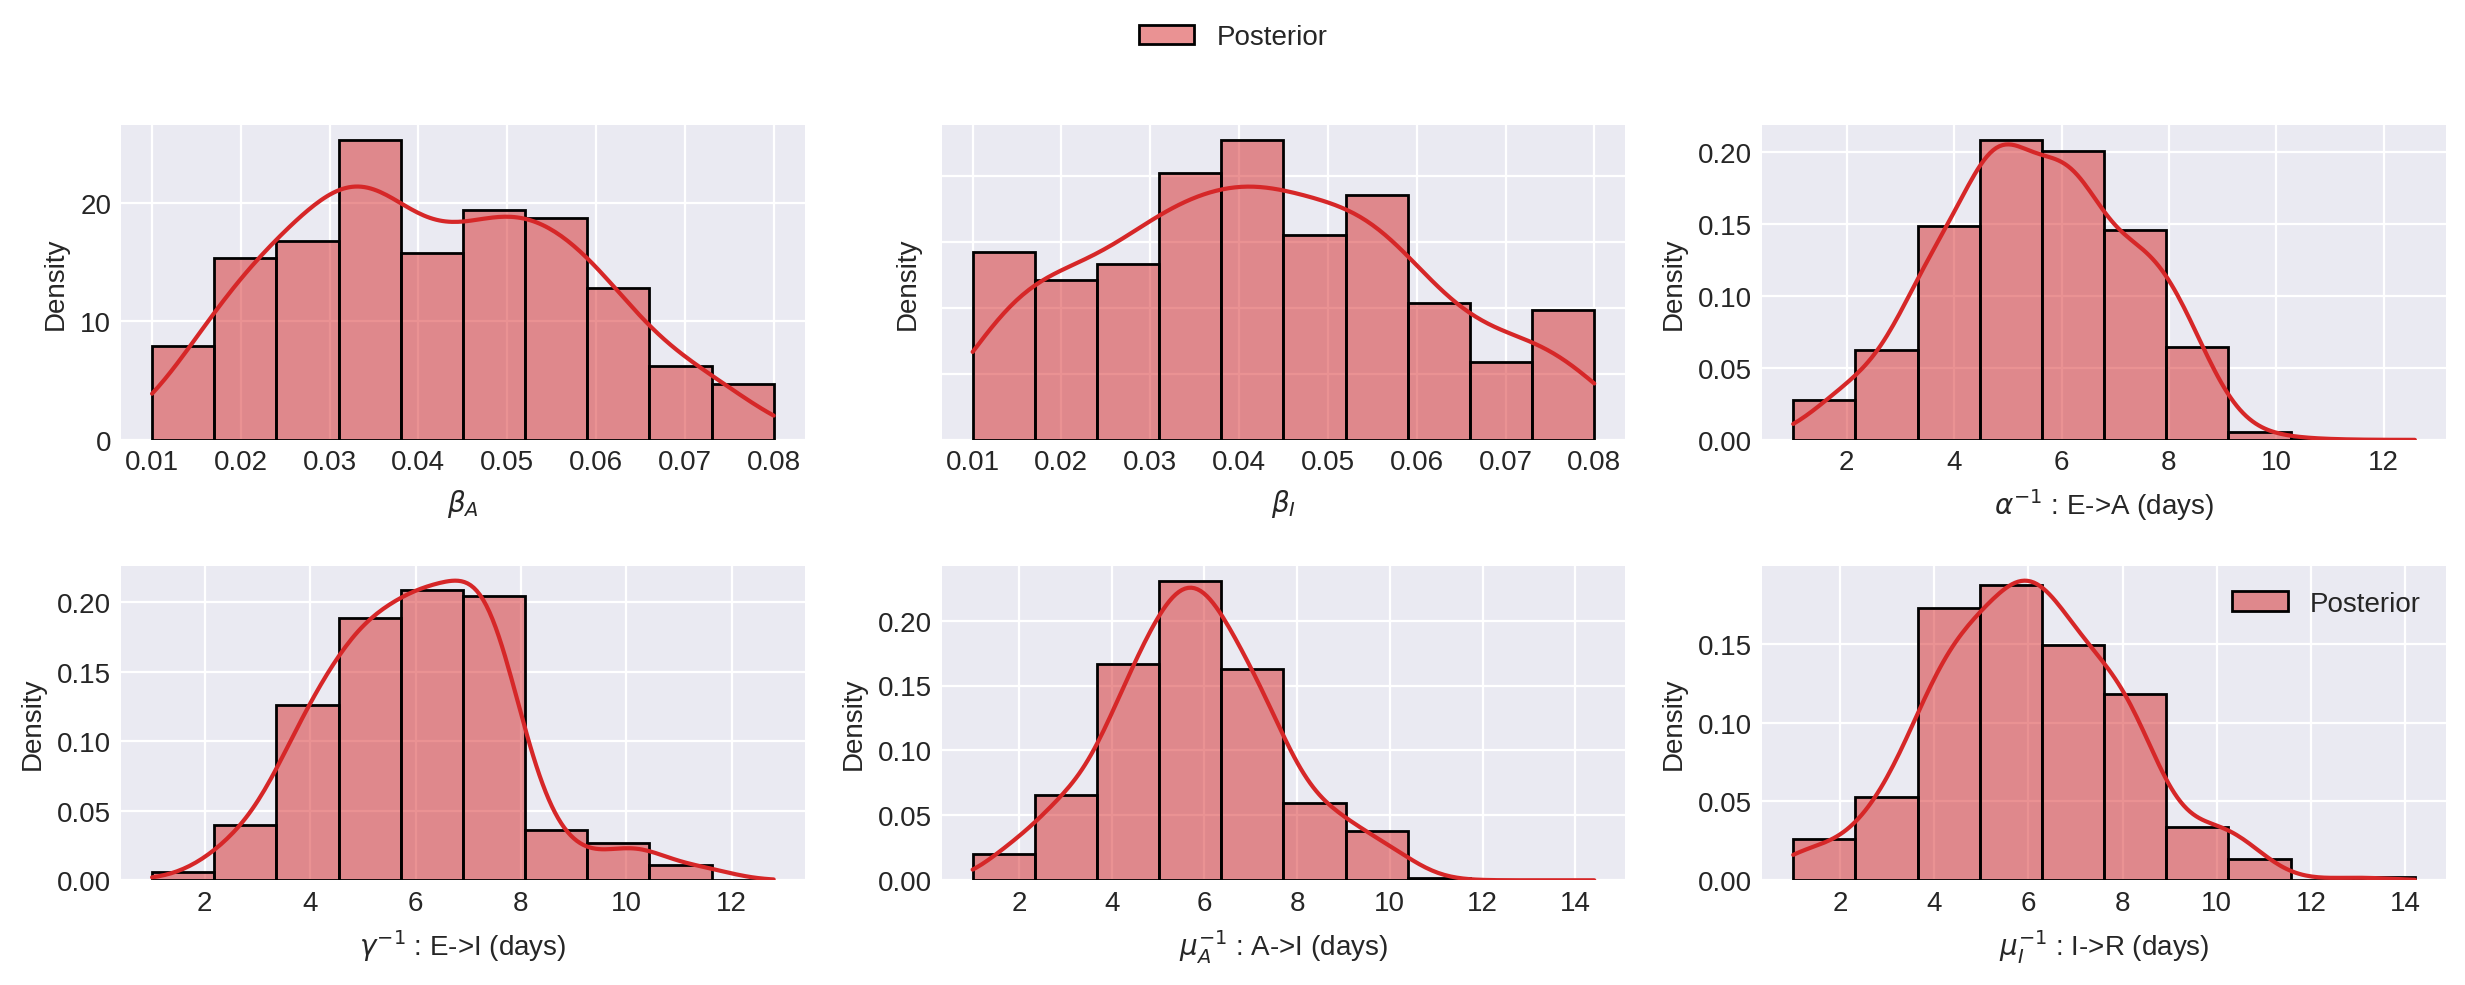

In [56]:
E_A, E_I, A_R, I_R, start_exposed_dist, beta_dist = prior_param_dist
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,5), dpi=200)
sns.histplot(x=np.squeeze(beta_dist[...,0]), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[0,0], kde=True, stat="density")
axs[0,0].set_xlabel(r'$\beta_{A}$')

sns.histplot(x=np.squeeze(beta_dist[...,1]), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[0,1], kde=True, stat="density")
axs[0,1].set_xlabel(r'$\beta_{I}$')

sns.histplot(x=np.squeeze(E_A), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[0,2], kde=True, stat="density")
axs[0,2].set_xlabel(r'$\alpha^{-1}$ : E->A (days)')

sns.histplot(x=np.squeeze(E_I), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[1,0], kde=True, stat="density")
axs[1,0].set_xlabel(r'$\gamma ^{-1}$ : E->I (days)')

sns.histplot(x=np.squeeze(A_R), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[1,1], kde=True, stat="density")
axs[1,1].set_xlabel(r'$\mu_{A} ^{-1}$ : A->I (days)')

sns.histplot(x=np.squeeze(I_R), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[1,2], kde=True, stat="density")
axs[1,2].set_xlabel(r'$\mu_{I}^{-1}$ : I->R (days)')


handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
plt.subplots_adjust(hspace=0.4)
# axs[-1, -1].axis('off')
axs[0,1].set_yticklabels('')
plt.legend()
# sns.displot(x=np.squeeze(beta_dist),stat="density", kde=True)

# Compare posterior with prior

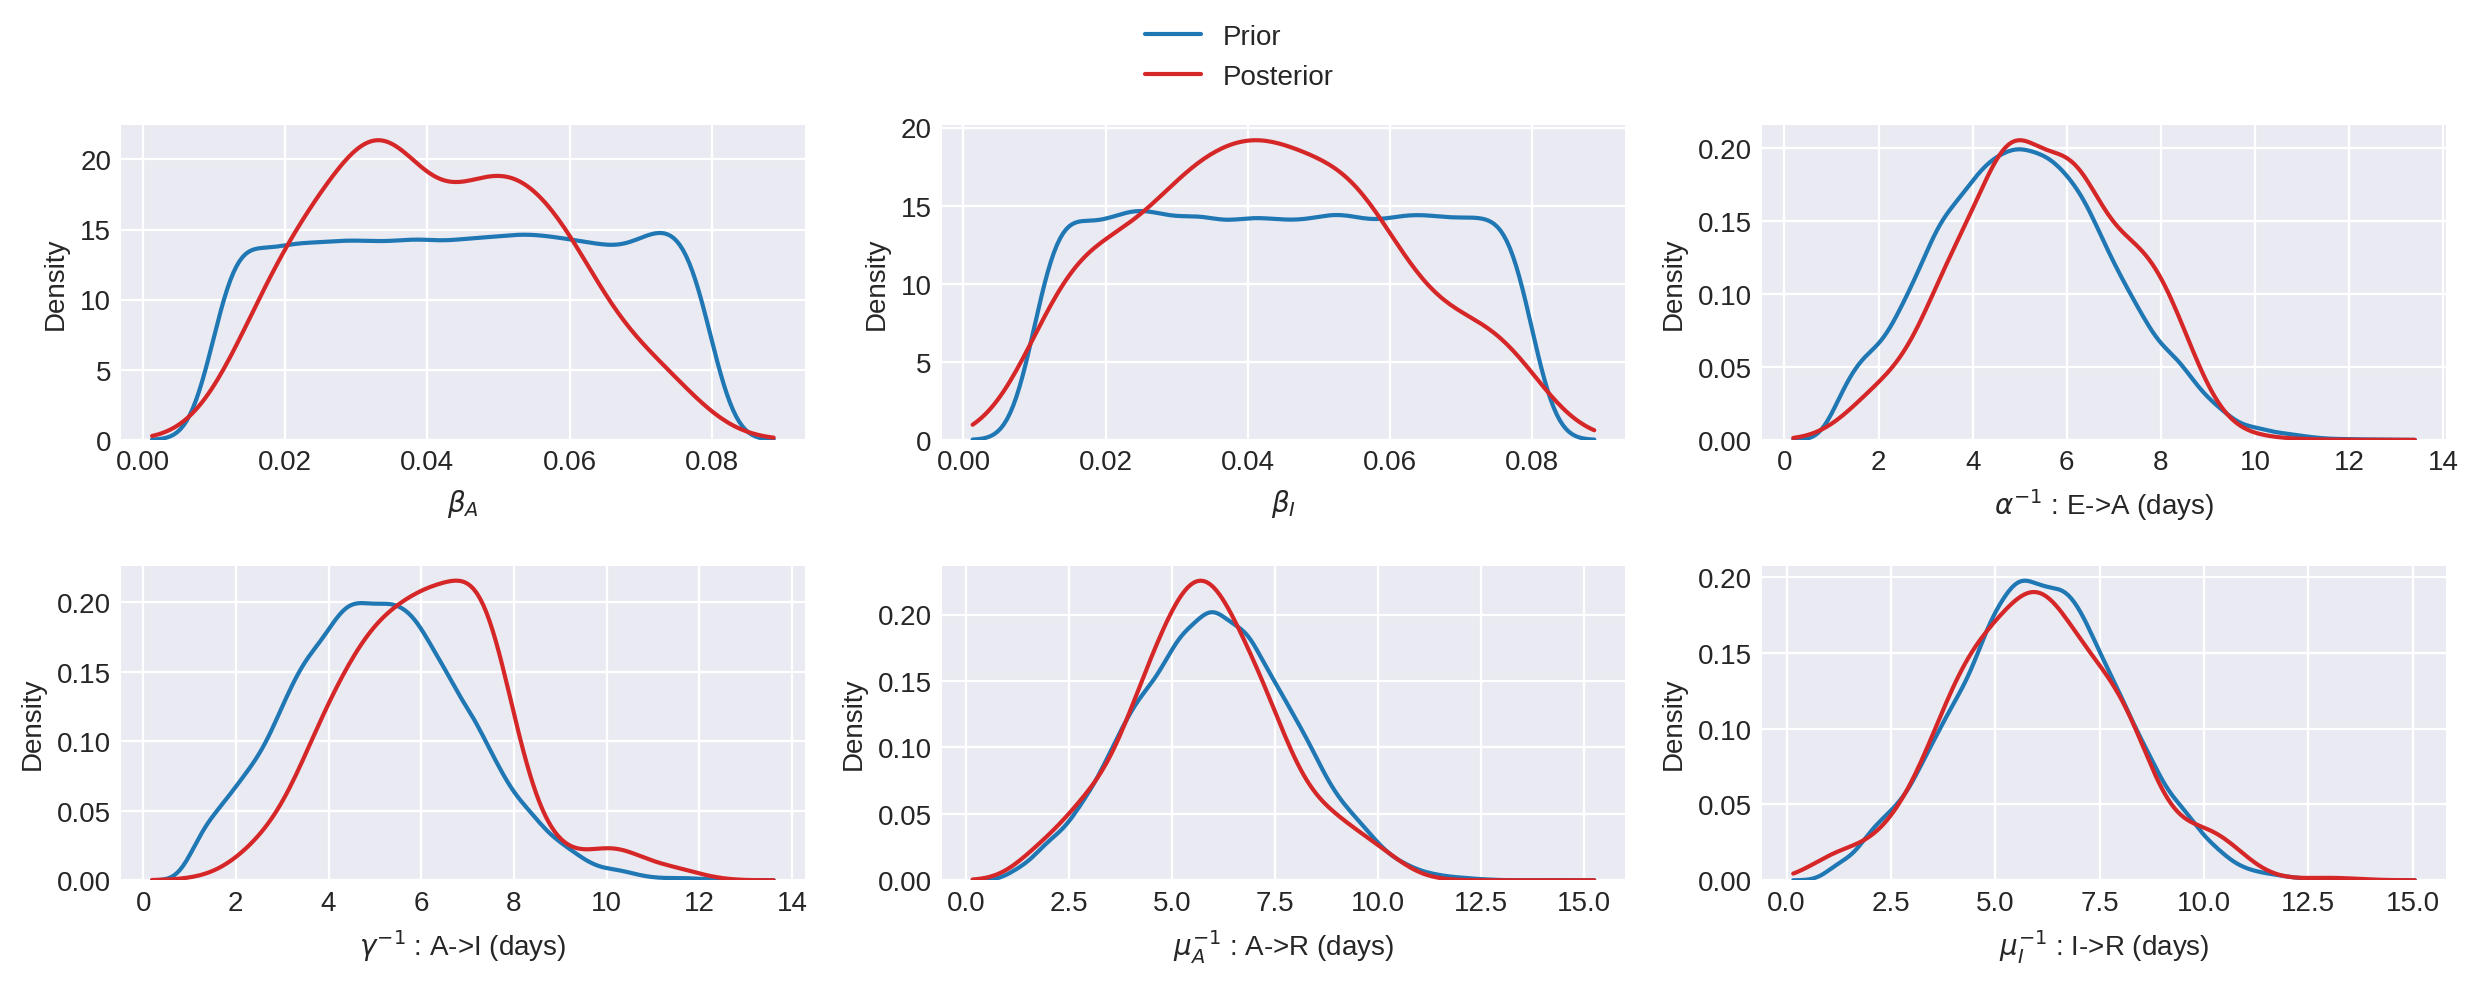

In [57]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,5), dpi=200)
sns.kdeplot(x=np.squeeze(beta_dist[...,0]), label='Prior',
            color='C0', ax=axs[0,0])
sns.kdeplot(x=np.squeeze(beta_dist[...,0]), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[0,0])
# sns.histplot(x=np.squeeze(beta_dist), weights=hme_model.traj_weights, label='Posterior',
#             color='C3', ax=axs[0,0], stat="density",kde=True)
axs[0,0].set_xlabel(r'$\beta_{A}$')
sns.kdeplot(x=np.squeeze(beta_dist[...,1]), label='Prior',
            color='C0', ax=axs[0,1])
sns.kdeplot(x=np.squeeze(beta_dist[...,1]), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[0,1])
axs[0,1].set_xlabel(r'$\beta_{I}$')

# sns.displot(x=np.squeeze(beta_dist),stat="density", kde=True)
sns.kdeplot(x=np.squeeze(E_A), label='Prior',
            color='C0', ax=axs[0,2])
sns.kdeplot(x=np.squeeze(E_A), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[0,2])
axs[0,2].set_xlabel(r'$\alpha^{-1}$ : E->A (days)')

sns.kdeplot(x=np.squeeze(E_I), label='Prior',
            color='C0', ax=axs[1,0])
sns.kdeplot(x=np.squeeze(E_I), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[1,0])
axs[1,0].set_xlabel(r'$\gamma ^{-1}$ : A->I (days)')

sns.kdeplot(x=np.squeeze(A_R), label='Prior',
            color='C0', ax=axs[1,1])
sns.kdeplot(x=np.squeeze(A_R), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[1,1])
axs[1,1].set_xlabel(r'$\mu_{A}^{-1}$ : A->R (days)')

sns.kdeplot(x=np.squeeze(I_R), label='Prior',
            color='C0', ax=axs[1,2])
sns.kdeplot(x=np.squeeze(I_R), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[1,2],legend=False)
axs[1,2].set_xlabel(r'$\mu_{I}^{-1}$ : I->R (days)')

handles, labels = axs[0,0].get_legend_handles_labels()
# axs[1,2].get_legend().set_visible(False)
fig.legend(handles, labels, loc='upper center')
plt.subplots_adjust(hspace=0.4)
# axs[-1, -1].axis('off')
# plt.legend()
plt.savefig('compare_param_dist.png', dpi=300)

In [58]:
me_w = me_model.traj_weights
prior_exposed_patch = maxentep.exposed_finder(trajs)
posterior_exposed_prob = maxentep.weighted_exposed_prob_finder(prior_exposed_patch, M, weights = me_w)


In [59]:
# maxentep.p0_map(prior_exposed_patch, M, weights = None, patch_names=patches, title = 'Prior patient-zero probability', fontsize=10, figsize=(10,8))
# maxentep.p0_map(prior_exposed_patch, M, weights = me_w, patch_names=patches, title = 'Posterior patient-zero probability', fontsize=10,figsize=(10,8))

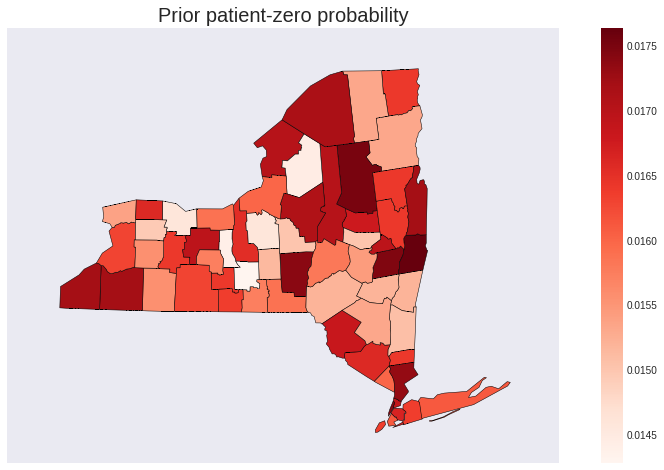

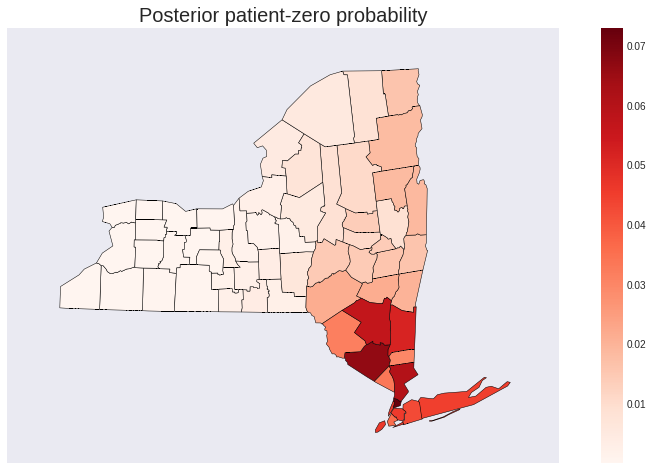

In [60]:
maxentep.p0_map(prior_exposed_patch, M, weights = None, patch_names=patches, title = 'Prior patient-zero probability', fontsize=20, choropleth=True,
       geojson='counties_ny.geojson')
maxentep.p0_map(prior_exposed_patch, M, weights = me_w, title = 'Posterior patient-zero probability', patch_names=patches, fontsize=20
      , choropleth=True, geojson='counties_ny.geojson')

Finding the top 5 most probable locations for the origin of outbreak:

In [61]:
sorted(zip(posterior_exposed_prob, patches), reverse=True)[:5]

[(0.0729743275457493, 'Bronx County'),
 (0.06667174278852267, 'Orange County'),
 (0.06042301080280871, 'Westchester County'),
 (0.05682710895911053, 'Ulster County'),
 (0.051817504808010326, 'Dutchess County')]

# Evaluating results

In [84]:
def find_mode(param, weights):
    ax = sns.histplot(x=np.squeeze(param), weights=weights, label='Posterior',
                color='C3', kde=True, stat="density")
    kdeline = ax.lines[0]
    xs = kdeline.get_xdata()
    ys = kdeline.get_ydata()
    plt.close()
    return xs[np.argmax(ys)]

In [96]:
maxent_prams =[]
for x in [beta_dist[...,1], beta_dist[...,0], E_A, E_I, A_R, I_R]:
    maxent_prams.append(find_mode(x,me_w))
beta_I_inferred, beta_A_inferred, alpha_inferred, gamma_inferred, mu_A_inferred, mu_I_inferred  = maxent_prams
# Finding eta and epsilon:
eta_inferred = 1/(1/alpha_inferred + 1/gamma_inferred)
epsilon_inferred = 1 - 1/alpha_inferred * eta_inferred

In [103]:
k = ['beta_I', 'beta_A', 'epsilon', 'eta', 'mu_A', 'mu_I' ]
v = [beta_I_inferred, beta_A_inferred, epsilon_inferred, eta_inferred, mu_A_inferred, mu_I_inferred]
maxent_prams_dict = dict(zip(k,np.round(v,3)))

True parameters:

$\beta_{I} = 0.052113$, &nbsp;   $\beta_{A} = 0.028905$, &nbsp;   $\epsilon = 0.586028$, &nbsp; $\eta = 2.492673$,  &nbsp; $\mu = 4.897089$  


Inferred prameters:

In [104]:
maxent_prams_dict

{'beta_I': 0.041,
 'beta_A': 0.033,
 'epsilon': 0.426,
 'eta': 2.878,
 'mu_A': 5.717,
 'mu_I': 5.914}

## Theory 1
Basic reproductive number ($R_0$):

$ S \xrightarrow{\beta} E \xrightarrow{\eta} A \xrightarrow{\alpha} I \xrightarrow{\mu} R $

$R_0 = \frac{\beta S_0}{\alpha} +  \frac{\beta S_0}{\mu } $

$ t_{max} \sim \frac{log(S_0)}{\mu (R_0 -1)}$

In [62]:
# total_pop = np.sum(population)
# R0 = beta*total_pop*(1/alpha + 1/mu)

In [63]:
# t_max = np.log(total_pop)/mu/(R0-1)

In [64]:
# t_max